In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from datetime import timedelta, datetime
from pandas.io.json import json_normalize

from IPython.display import Image  
from operator import truediv
from statsmodels.graphics.mosaicplot import mosaic

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Table of Contents

1. What is Mood Listener?
1. What is Churn?
1. Response Variable
    1. Importing from Events Dataset
    2. Churn Threshold
    
2. Data Cleaning
    1. Test Devices
    2. iPod and iPad
    3. Summary
    
3. Data Wrangling and Feature Engineering
    1. Registered Users
    2. Device Models
    3. iOS Version 
    4. App Release 
    5. City and Country
    6. Acquisition Cohorts 

# What is Mood Listener?

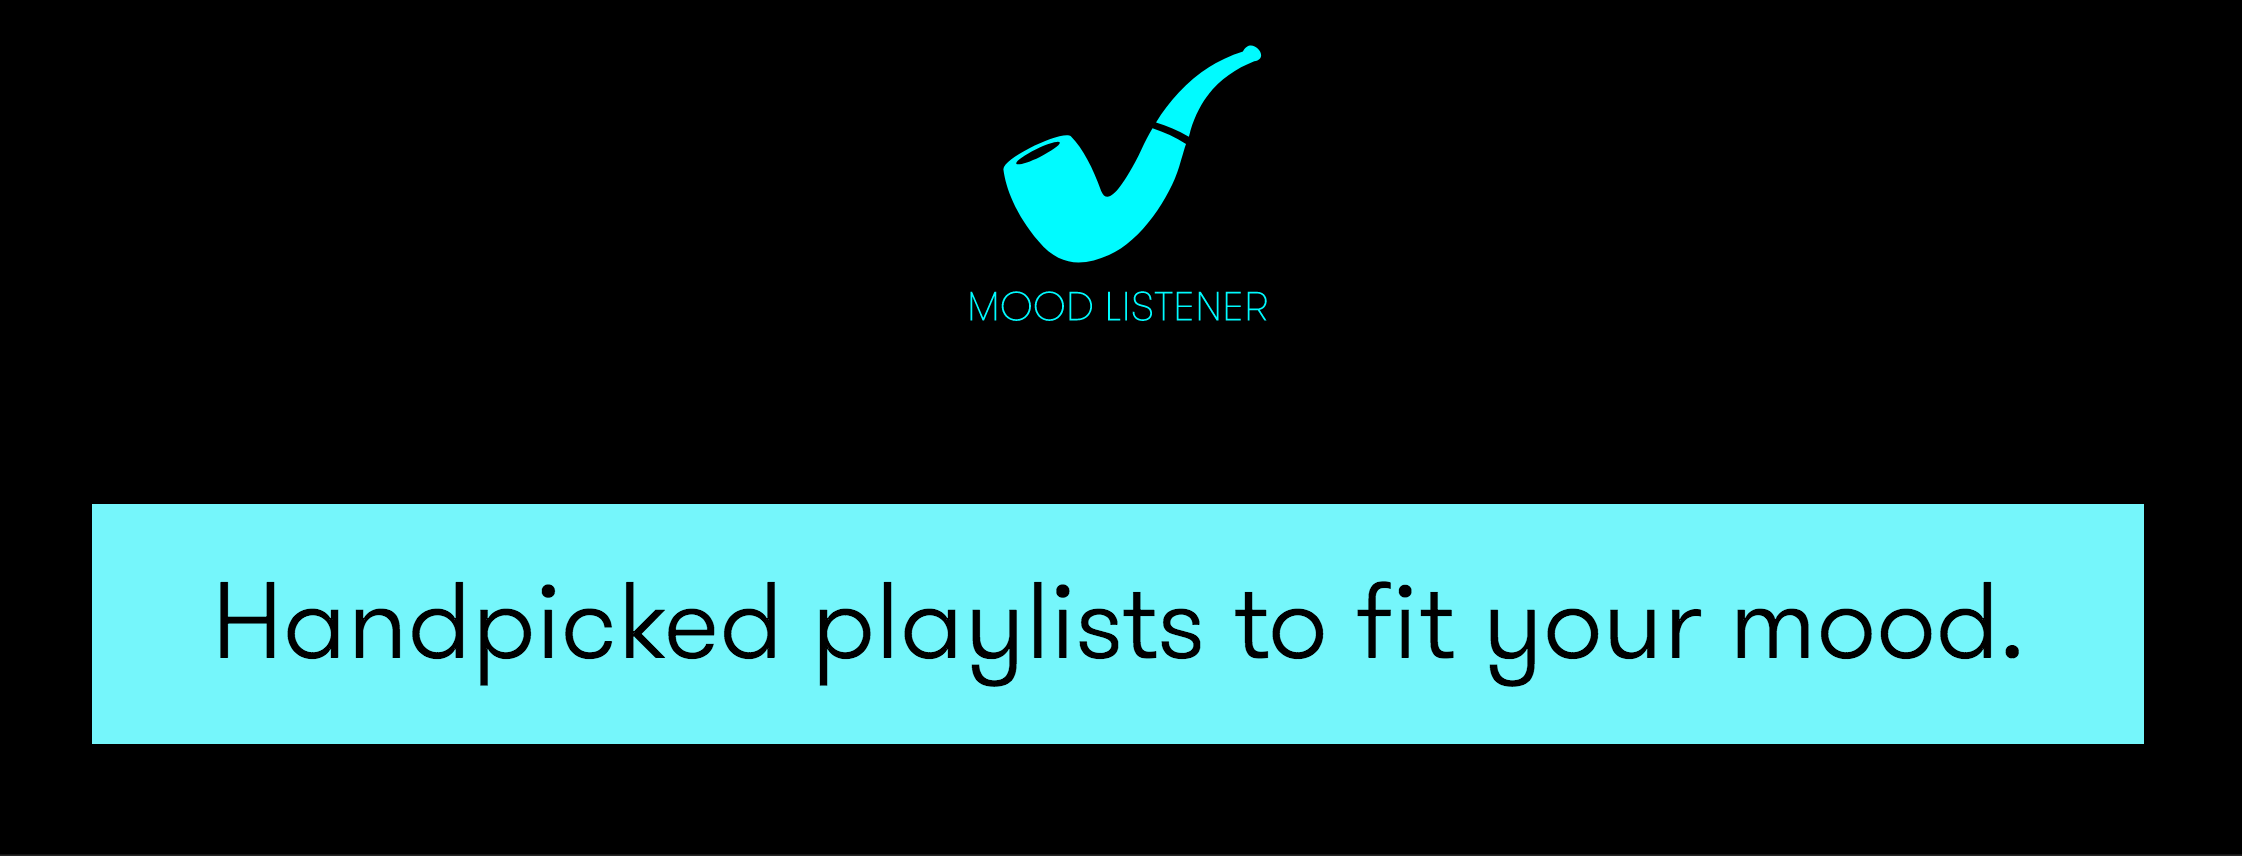

In [2]:
Image(filename='./assets/mood_listener.png')

[Mood Listener](http://www.moodlistener.com) is an iOS application created by my company [Bear & Fox](http://www.bearandfox.co/projects.html) as a side project in our free time. It is a collection of music playlists handpicked by us, tailored to different moods such as 'good morning', 'rainy days' etc. The music can be streamed through the application which is sourced by SoundCloud API. It is a lightweight, simple to use app for a group of people that shares a particular music taste. You can download the app from this [link](https://itunes.apple.com/gb/app/mood-listener/id1033906190?l=tr&mt=8).

The app was released in the Apple App Store in September 2015. Shortly after launch, it was featured in [producthunt.com](http://www.producthunt.com) and was listed in top 10 for the day, reaching as high as second position. This lead to the attention of multiple media outlets, where the app was published in multiple sources including [AppAdvice](http://www.appadvice.com). Publications has lead to some spikes in downloads, however, we have decided to follow a particular acquisition strategy. We contacted the owners of Turkey based popular instagram accounts that were sharing type of posts that we believed to be inline with the music we have been curating. We have started an [instagram account](https://www.instagram.com/mood_listener/) sharing a taste of music in the form of short music videos along with images. We have collaborated with the these popular instagram accounts by featuring them in the Mood Listener application in the form of custom playlists, letting them broadcast the news to their followers. This has lead to as much as 17,000 followers on Instagram and a good number of downloads. We have received around 10,000 downloads in general over 2 years with a quite loyal customer base.  

# What is Churn?

As described in [this](http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html) blog post; 

"Churn Rate is a business term describing the rate at which customers leave or cease paying for a product or service. It's a critical figure in many businesses, as it's often the case that acquiring new customers is a lot more costly than retaining existing ones (in some cases, 5 to 20 times more expensive)."

In broad terms, churn is user inactivity. However, it is usually a vague term that is defined in various ways depending on the use case. In our case, I will be defining a churned user as a user that downloads, uses the app once and and never comes back. Therefore I will we investigating the causes of this behaviour and, hopefully, accurately predict wether a user will 'churn' on day 1 based on its demographic features. 

# Introduction

This notebook outlines methods for predicting churn for users of the iOS app Moodlistener. Two datasets (Events and People) obtained through [Mixpanel API](https://mixpanel.com/) are used for modelling. First part of the project covers extensive Exploratory Data Analysis of the People dataset, this notebook will build up on those findings to prepare by pre-processing raw data as features to models we will implement on the next section.  

In the [next notebook titled 'Modelling'](./Modelling.ipynb), we will try to achieve 2 business outcomes; 
    
1. Build models for predicting churn on day 1 with high precision. Our aim is to improve retention by predicting churn before it happens. We hope to achieve this by automating a personalised push notification process to users who are likely to churn.
2. Apply feature selection to obtain actionable insights by understanding churn. These insights will guide us through strategising future acquisition campaigns and product development roadmap. 


# Churn - Response Variable

Starting by importing people dataset. 

In [3]:
people = pd.read_csv('./data/people/people_export_CONFIDENTIAL.csv') #read raw people csv
# people.head(3) CONFIDENTIAL

The aim of the project is to predict if a user (given features) is going to churn within a certain time period. I will pick this time period after data cleaning and EDA. In order to create churn column, I need to calculate the active duration for each user (amount of days from signup date to last seen date). Lets for look at last_seen column. 

In [4]:
print 'missing values: ' + str(people['$last_seen'].isnull().sum())

missing values: 0


In [5]:
people['$last_seen'].head() # check data format 

0    2016-02-10T15:39:46
1    2015-12-26T12:12:42
2    2016-02-13T22:35:36
3    2016-02-15T13:53:24
4    2016-03-24T12:25:18
Name: $last_seen, dtype: object

I will only keep the dates (remove time) and convert to pandas datetime format.

In [6]:
people['$last_seen'] = people['$last_seen'].map(lambda x: x.split('T')[0]) #remove time field 

In [7]:
people['$last_seen'] = people['$last_seen'].map(lambda x: pd.datetime.strptime(x, '%Y-%m-%d')) #convert to datetime

In [8]:
people['$last_seen'].head()
# successfully converted to datetime64 type

0   2016-02-10
1   2015-12-26
2   2016-02-13
3   2016-02-15
4   2016-03-24
Name: $last_seen, dtype: datetime64[ns]

Lets check Signup Date and see if I we can calculate the active duration column.

### Signup Date

In [9]:
people['Signup Date'].head()

0    2015-09-04T18:22:28
1    2015-12-26T12:12:42
2    2016-02-13T21:20:42
3    2016-02-15T13:53:24
4    2016-02-20T19:17:01
Name: Signup Date, dtype: object

In [10]:
people['Signup Date'].isnull().value_counts()
# missing values for the signup_date column 

False    8728
True     1750
Name: Signup Date, dtype: int64

After spending some time digging into Objective-C (source) code for different app version releases and trying to cross correlate with the data, it turns out that signup_date is not reliable. For different app releases, the position in code for this tracker has changed a lot, giving different results for different users, sometime even failing to provide a value at all. For this reason I will drop this column.

In [11]:
people = people.drop('Signup Date', axis=1) #drop signup date

Inaccurate information contained in Signup Date has caused a problem. People dataset doesn't contain another column that I can calculate the duration for each user. As a result, I need to use 'Events' dataset that includes event based data of each user. I will query the Mixpanel API for all the entries with 'App Launched' event tag. By finding the first 'App Launch' event for each user, I can find the day that the user first used the app, therefore, I can calculate the duration column. 

##  Importing from Events Dataset

Mixpanel API starts returning Timeout error when I query for more than 2 months period. I will read JSON files from API for 2 months from the first day to 15 April 2017. I will read a 2 month chunk, transform it to the desired dataframe and repeat this procedure until I aggregate all the values in a single dataframe. 

Reading below the json returned for date restricted query, where event=='App Launched', and I will only keep distinct_id and timestamp of each event. Source code for API query can be found in './data/pull-events.py'.

In [12]:
launch_event_chunk = pd.read_json('./data/events/app_launched/2017-04-15.txt') #file is in JSONL format so extra step below needed
properties_chunk = pd.DataFrame.from_records(launch_event_chunk['properties']) # reformat properties
properties_chunk = properties_chunk[['distinct_id','time','$app_release']] #only keep userid, app_release and timestamp

In [13]:
# properties_chunk.head(3) CONFIDENTIAL

Find the earliest app launch event timestamp for each user, assign it to a dataframe:

In [14]:
first_launch = properties_chunk.groupby('distinct_id').min() #group by users and find the earliest app launch by the user
first_launch['distinct_id'] = first_launch.index #assign index to a column (groupby assigns column to index)
first_launch.index = range(0,first_launch.shape[0]) #reset index back to 0 to total row count  
# first_launch.head(3)

Now, I will apply the same procedure to each JSON file (2 months period each) and keep appending to my final dataframe:

In [15]:
def transform_events_json(file_path):
    launch_event_chunk = pd.read_json(file_path) #file is in JSONL format so extra step below needed
    properties_chunk = pd.DataFrame.from_records(launch_event_chunk['properties']) # reformat properties
    properties_chunk = properties_chunk[['distinct_id','time','$app_release']] #only keep user id and timestamp of app launched event
   
    app_launch = properties_chunk.groupby('distinct_id').min() #group by users and find the earliest app launch by the user
    app_launch['distinct_id'] = app_launch.index #assign index to a column (groupby assigns column to index)
    app_launch.index = range(0,app_launch.shape[0]) #reset index back to 0 to total row count  
    
    return app_launch

In [16]:
feb_17 = transform_events_json('./data/events/app_launched/2017-02-15.txt') #read the previous 2 months 
# feb_17.head(3) CONFIDENTIAL

Now I will append the new dataframe to my main dataframe, however, there will be users that exists in both dataframes, so I will only keep the minimum date for each user.

In [18]:
print first_launch.shape, feb_17.shape #checking shapes before appending 

(1738, 3) (1101, 3)


In [19]:
first_launch = first_launch.append(feb_17) #append previous chunk to main dataframe 

In [20]:
print first_launch.shape 
# successfully appended 

(2839, 3)


Again, I need to drop users that appear more than once, only keeping the minimum timestamp. 

In [21]:
first_launch = first_launch.groupby('distinct_id').min() #drop duplicate users, keep minimum time 
first_launch['distinct_id'] = first_launch.index #assign index to a column (groupby assigns column to index)
first_launch.index = range(0,first_launch.shape[0]) #reset index back to 0 to total row count  

print first_launch.shape
#succesfully dropped duplicate users, only keeping the minimum time

(2282, 3)


I will now repeat the same procedure for all of the remaining chunks.

In [22]:
def append_and_drop(main_df, file_path):
    transformed_df = transform_events_json(file_path) #call method that reads and cleans to df.
    print 'new chunk size: ' + str(transformed_df.shape[0]) #size of sub df 
    print 'main dataframe size: ' + str(main_df.shape[0])
    
    main_df = main_df.append(transformed_df) #append to main df     
    main_df = main_df.groupby('distinct_id').min() #drop duplicates    
    main_df['distinct_id'] = main_df.index #assign index to a column (groupby assigns column to index)
    main_df.index = range(0,main_df.shape[0]) #reset index back to 0 to total row count  
    print 'main dataframe size after append/drop: ' + str(main_df.shape[0])

    return main_df

In [23]:
json_filenames = !ls ./data/events/app_launched/*.txt #read all events json file names to a list 
print 'number of events data files: ' + str(len(json_filenames))

number of events data files: 10


I have already imported 2 of the files. I will drop them from the list. 

In [24]:
json_filenames.remove('./data/events/app_launched/2017-02-15.txt') #drop Feb 17
json_filenames.remove('./data/events/app_launched/2017-04-15.txt') #drop Apr 17
print 'number of events data files: ' + str(len(json_filenames))

number of events data files: 8


In [25]:
first_launch.shape

(2282, 3)

In [26]:
for filename in json_filenames: #loop through the filenames 
    first_launch = append_and_drop(first_launch.copy(), filename) #read each json append to main dataframe and drop duplicates

new chunk size: 299
main dataframe size: 2282
main dataframe size after append/drop: 2578
new chunk size: 329
main dataframe size: 2578
main dataframe size after append/drop: 2859
new chunk size: 2962
main dataframe size: 2859
main dataframe size after append/drop: 5565
new chunk size: 4216
main dataframe size: 5565
main dataframe size after append/drop: 8424
new chunk size: 3291
main dataframe size: 8424
main dataframe size after append/drop: 9790
new chunk size: 1927
main dataframe size: 9790
main dataframe size after append/drop: 10237
new chunk size: 1403
main dataframe size: 10237
main dataframe size after append/drop: 10572
new chunk size: 1228
main dataframe size: 10572
main dataframe size after append/drop: 10786


In [27]:
first_launch.info()
# main dataframe is ready with no missing values 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10786 entries, 0 to 10785
Data columns (total 3 columns):
time            10786 non-null int64
$app_release    10786 non-null object
distinct_id     10786 non-null object
dtypes: int64(1), object(2)
memory usage: 337.1+ KB


In [28]:
# first_launch.head(3) CONFIDENTIAL

time column is in an unexpected format. Mixpanel website provides further information about this:

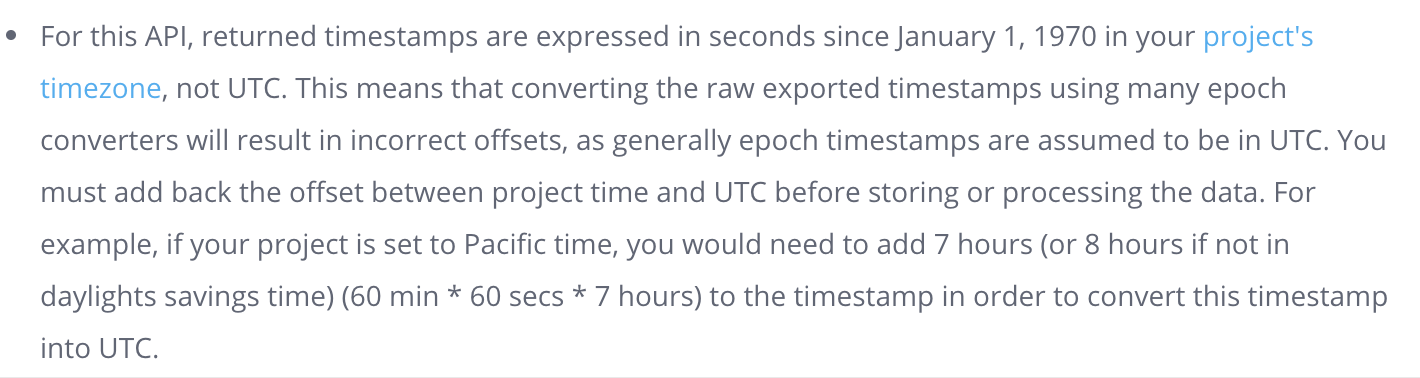

In [29]:
Image(filename='./assets/time_format.png') # saved to local directory from Mixpanel website 

This is how I can convert time values to datetime format to match last_seen column values.

In [30]:
datetime.fromtimestamp(1444950417)

datetime.datetime(2015, 10, 16, 0, 6, 57)

In [31]:
datetime.fromtimestamp(1444950417) - timedelta(hours=8) #read seconds from epoch and convert to project timezone UTC-8

datetime.datetime(2015, 10, 15, 16, 6, 57)

After confirming the converting approach above works, I can now convert time to datetime format (keeping only dates)

In [33]:
first_launch['time'] = first_launch.time.map(lambda x: (datetime.fromtimestamp(x) - timedelta(hours=8)))
# first_launch.head(3) CONFIDENTIAL

I will now merge time column back to my raw people dataset

In [34]:
print people.shape, first_launch.shape #checking shapes before merge

(10478, 23) (10786, 3)


In [35]:
people = pd.merge(people, first_launch, how='left', left_on='Device ID', right_on='distinct_id')
people = people.rename(columns={'time': 'signup_date'}) #rename the column appropriately 

#### NOTE

I have also kept the app_release column to overwrite the ios_app_release column I already had in people dataset. ios_app_release is always up to date, so if a user is active for a long period, ios_app_release will update accordingly. I have realised during modelling that this is introducing bias. I will be using the app release that each user had on day 1. 

In [36]:
people = people.drop('$ios_app_release', axis=1) #change recent app release to app release on day 1 for each user. 

In [37]:
na_counts = people.signup_date.isnull().sum()
print 'missing signup date entries: ' + str(na_counts)

missing signup date entries: 30


Users with missing values are the ones who has downloaded the app but never used. Since the number is very small compared to total number of users, I will drop them. 

In [38]:
drop_ind = people[people.signup_date.isnull()].index #get indices for missing signup dates 
people = people.drop(drop_ind) #drop entries with indices above

In [39]:
print people[['signup_date','$last_seen']].head() #check values 
people[['signup_date','$last_seen']].dtypes

          signup_date $last_seen
0 2015-09-04 11:22:29 2016-02-10
1 2015-12-26 04:12:42 2015-12-26
2 2016-02-13 13:20:42 2016-02-13
3 2016-02-15 05:53:24 2016-02-15
4 2016-02-20 11:17:02 2016-03-24


signup_date    datetime64[ns]
$last_seen     datetime64[ns]
dtype: object

In [40]:
time_deltas = people['$last_seen'] - people['signup_date']
time_deltas.head()

0   158 days 12:37:31
1   -1 days +19:47:18
2   -1 days +10:39:18
3   -1 days +18:06:36
4    32 days 12:42:58
dtype: timedelta64[ns]

Some results show -1 as displayed above, which doesn't make sense. This is because at one column we have date and time information and in another column we have only have dates, which sets the time 00.00 automatically, therefore, when we are subtracting times there is a slight shift that causes some 0 day differences to -1. I will simply set them to 0, but before that I will only get the day differences in integer format. 

In [41]:
time_deltas = time_deltas.map(lambda x: x.days)  #get only days from timedelta values
time_deltas = time_deltas.map(lambda x: 0 if x < 0 else x) #convert -1 values to 0, keep rest
time_deltas.head() #successfully converted

0    158
1      0
2      0
3      0
4     32
dtype: int64

In [42]:
people['duration'] = time_deltas  
#finally assigning active day durations for each user to the 'duration' column 

These values are actually off by 1 day. If the app launch date and last seen date are the same for a user, the difference will be 0, however, that user has used the app for 1 day. For that reason, I will increment duration column by 1.

In [43]:
people['duration'] = people['duration'] + 1 #increment duration by 1 for each user. 

## Churn Threshold

Our main goal is to predict wether a user will churn within X days, given their static features. To pick the right value for such threshold, I will visualise the data. 

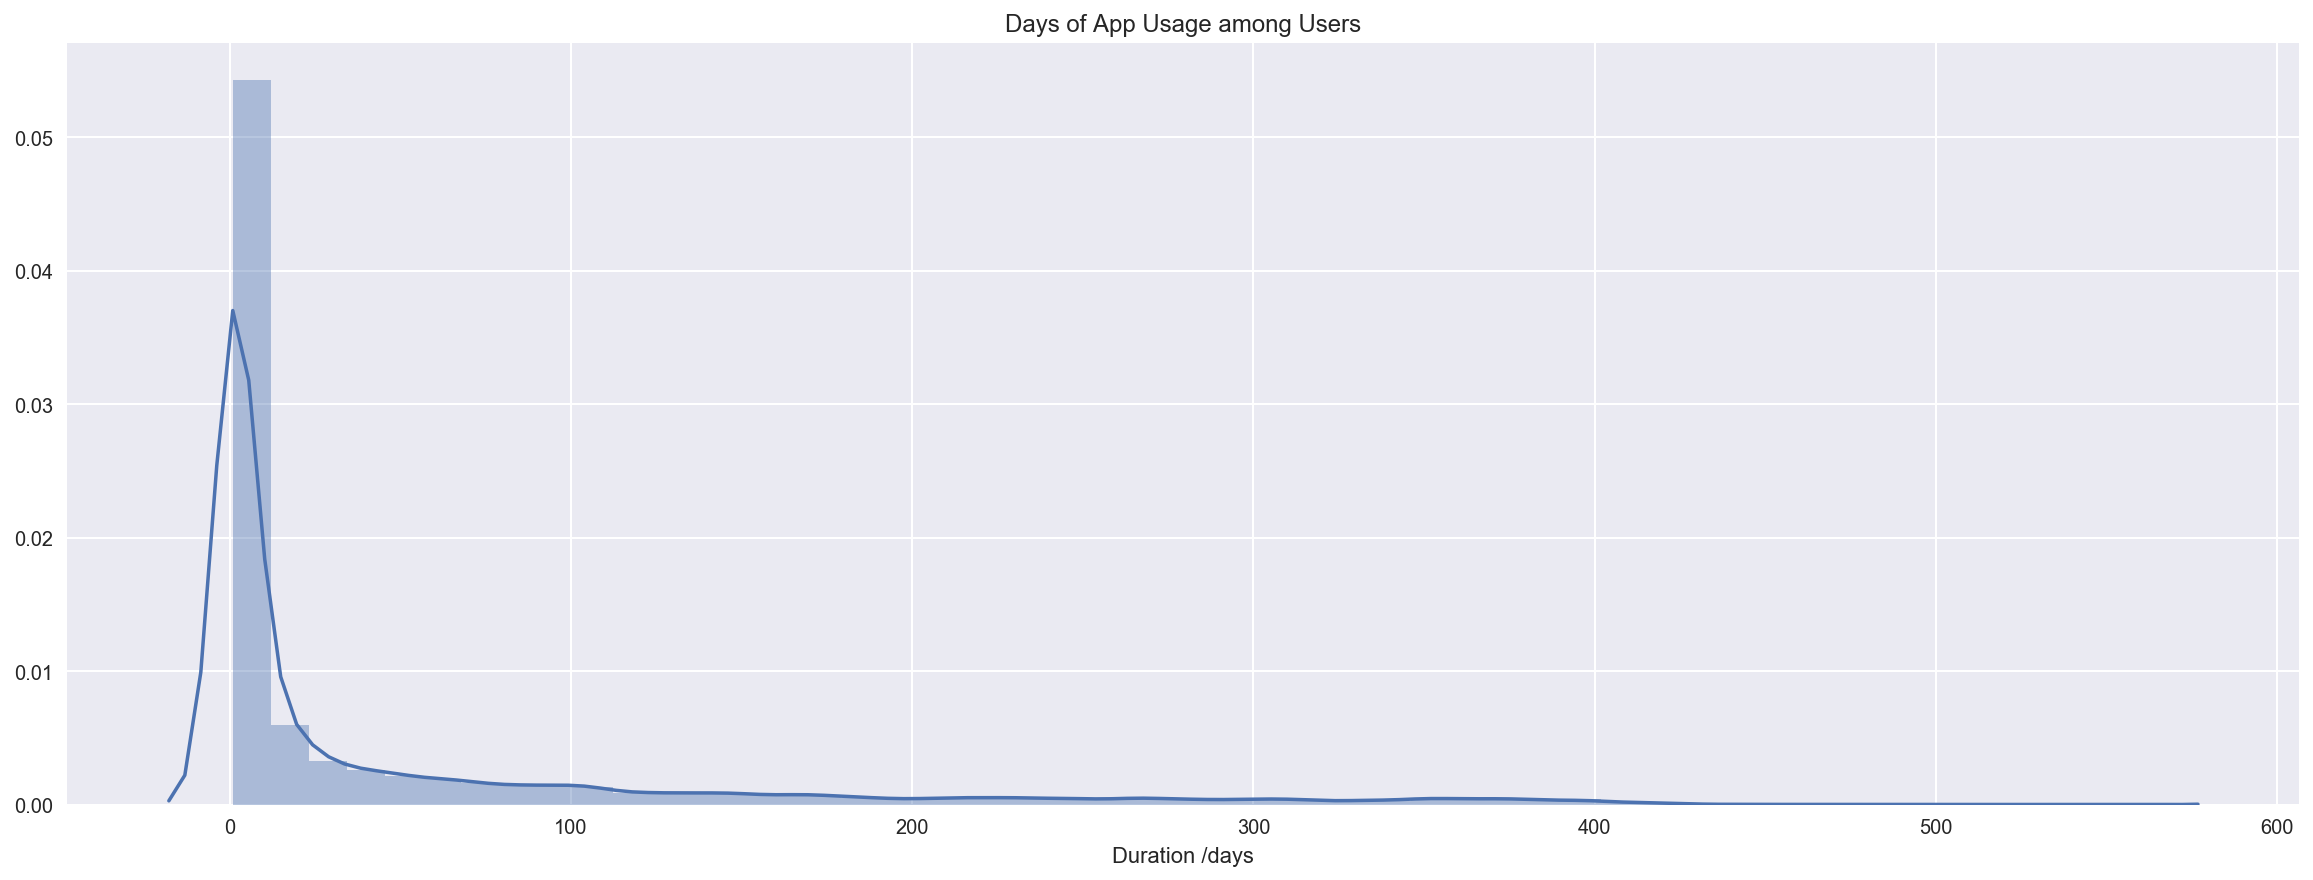

In [45]:
fig = plt.figure(figsize=(20,7))#set size 
ax = fig.gca()
ax = sns.distplot(people.duration, hist=True, ax=ax) #duration distribution among users 
ax.set_title('Days of App Usage among Users') #set title and labels
ax.set_xlabel('Duration /days')
plt.show()

Above plot shows that a very large proportion of our users never come back after trying out the app once, and there are users who have very large duration amounts. This is expected since majority of the apps on App Store are never used after first day. I can confirm such behaviour looking at the percentage of users who has only used the app once. 

In [46]:
churned_day1 = people[people.duration == 1] #users who never came back. 
proportion = len(churned_day1) / float(len(people)) #getting proportion compared to all users
print 'percentage of users who churned on the first day: ' + str(proportion)

percentage of users who churned on the first day: 0.451761102603


Based on the findings above, there are two approaches to predicting churn;

1. Predict users who will churn on day 1. Mood Listener's value proposition does not meet the expectation of these users, therefore, they try the app and never come back. Predicting wether a new user is within this category can be very useful in our marketing efforts. It will act as a feedback loop for marketing campaigns targeting different demographic of users. 

2. Predict churn for users which has been active for more than 1 day. This approach will be useful for preventing churn for retained users through strategies like personlised push notifications or special offers etc.

I am assuming that the second approach is based more on the app usage patterns, which is included in the events dataset. However, people dataset that provides demographic information on users should be a better indicator churning on day 1. This is because, different demograhics will have different music taste that may or may not align with the music featured within the application. 

Looking at this problem from the business standpoint; we should think in terms of conversion funnels; acquisition, conversion and finally retention. We should start improving our funnel starting from the first stage which is the acquisition. Once we are start acquiring more users, we will have enough data to discover ways to improve retention, which is the next step. 

I should also consider class imbalance. Since there are limited number of users, setting a date range for churn will only consider minority of users, creating a class imbalance problem. There are ways to solve that problem such as over and under sampling, however this may reduce the statistical significance of our results. By going with the first approach, I will have a balanced classes on response variable. 

For the reasons stated above, I have concluded to take the first approach. We will model demographic features to predict wether an incoming user will churn on day 1. 

In [47]:
people['churn'] = people.duration.map(lambda x: 0 if x > 1 else 1) #users who used the app more than a day are retained.

In [48]:
people.churn.value_counts() 
# Successfully calculated a balanced response variable -churn 

0    5728
1    4720
Name: churn, dtype: int64

In [49]:
people_raw = people.copy() # keeping a copy before cleaning, in case if I need some columns later on. 

# Data Cleaning

In [50]:
people.columns

Index([      u'$distinct_id',          u'Device ID',  u'$ios_device_model',
                    u'$city',         u'$last_seen',          u'$timezone',
                    u'Email',     u'$notifications',      u'$country_code',
       u'Number of Sessions',              u'$name',   u'$ios_lib_version',
         u'Total Like Count',       u'$ios_version',         u'$campaigns',
         u'$ios_app_version',             u'$email',           u'$ios_ifa',
           u'$distinct_id.1',          u'Full Name',            u'$region',
           u'$predict_grade',        u'signup_date',       u'$app_release',
              u'distinct_id',           u'duration',              u'churn'],
      dtype='object')

From initial EDA, I have already observed the features. I will drop columns that are unneccessary for modelling churn on day 1;

1. Campaigns & Notifications: I assume none of the users received a push notification on the day that they download and tried the app.

2. Total Like Count & Number of Sessions: These two columns are also directly related to the amount of time a users have used the app, they will not contribute to predictions. 

3. Predict Grade: During EDA, I have observed that 99% of users are classified as either 'Converted' or 'Unlikely'. Since 'Converted' is for users who has launched the app at least twice, this column will not provide any information. 

4. Timezone & Region: Among 4 geo-location based features, country and city were the most accurate.

5. Duration: All the churned user have duration of 1, this column is not informative. 

6. Unused columns during EDA: there were many uninformative columns by default such as 'Device ID' that is spotted during EDA, these will also be dropped. 

In [51]:
first_stage_drops = ['$ios_lib_version','$ios_ifa','Full Name', '$distinct_id.1',
                              'Email', '$distinct_id','Device ID', '$name', 'distinct_id']
current_stage_drops = ['$campaigns', '$notifications', 'Total Like Count', 'Number of Sessions',
                      '$predict_grade', '$timezone', '$region', 'duration'] 
people = people.drop(first_stage_drops+current_stage_drops, axis=1) #drop all the redundant columns 

In [52]:
people.columns

Index([u'$ios_device_model',             u'$city',        u'$last_seen',
           u'$country_code',      u'$ios_version',  u'$ios_app_version',
                  u'$email',       u'signup_date',      u'$app_release',
                   u'churn'],
      dtype='object')

Columns should be renamed for consistency and readability. I will replace whitespaces with underscores, convert all the text to lowercase and remove special characters ($).

In [53]:
new_cols = people.columns.str.lower() #lowercase 
new_cols = new_cols.str.replace(' ','_') #whitespaces to underscores
new_cols = new_cols.str.replace('$','') #remove the special character
people.columns = new_cols # assign to dataframe
people.columns

Index([u'ios_device_model',             u'city',        u'last_seen',
           u'country_code',      u'ios_version',  u'ios_app_version',
                  u'email',      u'signup_date',      u'app_release',
                  u'churn'],
      dtype='object')

## Test Devices

During EDA, I have observed that there were some entries that is created during testing through XCode's Simulator software.

In [54]:
simulator_entries = people[people['ios_device_model'] == 'x86_64']
print 'Total Simulator entries: ' + str(len(simulator_entries))

Total Simulator entries: 576


In [55]:
people = people.drop(simulator_entries.index) #drop test devices

In [56]:
people.shape #reduced shape

(9872, 10)

## iPod and iPad

In [57]:
people['ios_device_model'].unique() #lets have a look at the unique values 

array(['iPhone7,2', 'iPhone8,1', 'iPhone6,2', 'iPhone5,2', 'iPhone5,1',
       'iPhone4,1', 'iPad6,8', 'iPad3,3', 'iPhone8,2', 'iPad3,1',
       'iPhone9,3', 'iPhone6,1', 'iPhone7,1', 'iPad3,6', 'iPad5,4',
       'iPad4,5', 'iPhone8,4', 'iPhone9,2', 'iPad5,3', 'iPad4,1',
       'iPhone5,3', 'iPad3,4', 'iPad4,2', 'iPod5,1', 'iPod7,1',
       'iPhone9,1', 'iPad4,4', 'iPad2,2', 'iPhone9,4', 'iPad6,7',
       'iPad2,5', 'iPad2,6', 'iPhone5,4', 'iPad4,8', 'iPad4,7', 'iPad5,1',
       'iPad3,5', 'iPad2,4', 'iPad2,1', 'iPad2,7', 'iPad5,2', 'iPad6,3',
       'iPad6,4'], dtype=object)

In [58]:
print 'missing values: ' + str(people['ios_device_model'].isnull().sum())

missing values: 0


Lets extract devices from ios_device_model string.

In [59]:
def extract_device_category(model_str): #extract device type from ios_device_model string 
    match = re.match(r"([a-z]+)([0-9]+)", model_str, re.I) #split characters and numbers 
    items = match.groups()
    return items[0] #return iPhone

In [60]:
people['device'] = people['ios_device_model'].map(extract_device_category) # only keep device category

In [61]:
people.device.value_counts() #value counts 

iPhone    9324
iPad       440
iPod       108
Name: device, dtype: int64

In [62]:
len(people[people.device != 'iPhone']) / float(len(people)) 
# only 5% of our users are using devices other than iPhone 

0.05551053484602917

Since 95% of users are using iPhone, using this feature will not contribute to the predictions. I will drop the outliers and then the column. 

In [63]:
# only keep users who are using iPhone (drop outliers)
non_iphone_ind = people[people.device != 'iPhone'].index #get indices of non-iPhone users 
people = people.drop(non_iphone_ind) #drop those entries 

In [64]:
people = people.drop('device', axis=1)

Now that we know all the users have iPhone as their device. We only need the model numbers.

In [65]:
people['ios_device_model'] = people.ios_device_model.map(lambda x: x[6:]) #model number always starts after 6'th character 

In [66]:
people.ios_device_model.unique()
# only kept the model numbers, since all entries are iPhone

array(['7,2', '8,1', '6,2', '5,2', '5,1', '4,1', '8,2', '9,3', '6,1',
       '7,1', '8,4', '9,2', '5,3', '9,1', '9,4', '5,4'], dtype=object)

## Summary 

1. Dropped redundant columns observed during EDA. 
2. Renamed columns for consistency 
3. Dropped test device (Simulator) entries.
4. Dropped iPad and iPhone devices. 

# Registered Users

In [68]:
# people['email'].head() CONFIDENTIAL

Email column is not useful for modelling, however, it informs about wether the user was signed up or using the app in guest mode.

As the first screen after downloading the application, Users choose to register through Email/Facebook or continue in guest mode. Even though it seems unlikely, there could be some users who signup on the first screen, try the app and never come back again. I will explore this further after convering email column to registered. 

In [69]:
people['email'] = (~people['email'].isnull()).astype(int) #convert inverse isnull() boolean array to int

In [70]:
people['email'].value_counts()
# 0: user is using the app in guest mode, 1: registered user

0    5611
1    3713
Name: email, dtype: int64

In [71]:
def plot_registered_for_churn(plot_data):
    
    # bar chart 
    fp = sns.factorplot(x='email', y='churn', data=plot_data, kind='bar')
    sns.plt.title('Churn Rates for Guests and Registered Users')

    fp.set_xticklabels(['Guest','Registered'])
    fp.set_ylabels('Churn Rate')
    fp.set_xlabels('')
    
    #mosaic chart 
    labelizer = lambda k: {('0', '0'): 'guest & active', ('0', '1'): 'guest & churned', #set labels
                      ('1', '0'): 'registered & active', ('1', '1'): 'registered & churned'}[k] 
    props = lambda key: {'color': '#4C72B0' if '0' == key[0] else '#55A868'} #set colors
    mosaic(plot_data, ['email','churn'], labelizer=labelizer, properties=props,
               title='Distribution of Users for Churn and Registration') 
    plt.show()

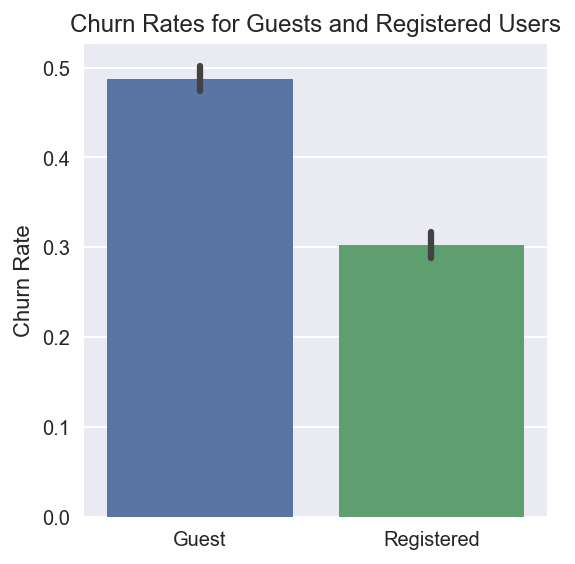

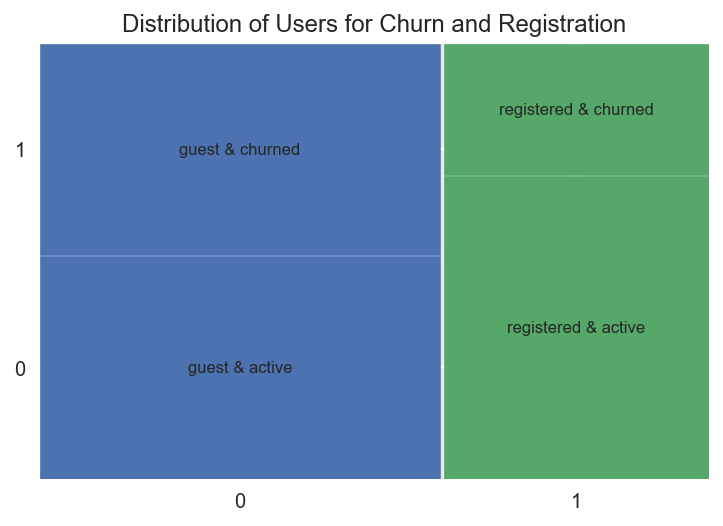

In [72]:
plot_registered_for_churn(people[['email','churn']])

It looks like when a user registers, they are more likely to stay active. However, if a user is not registered, we can't say much about wether that user will churn or not. Since I know both registered and churn columns have balanced classes, I will keep this column. 

In [73]:
people = people.rename(columns={'email':'registered'}) #rename email column to registered

# Device Models

In [74]:
people.ios_device_model.value_counts() #quickly checking counts

7,2    2740
8,1    1599
6,2    1543
5,2     750
7,1     614
6,1     466
8,2     458
4,1     343
5,1     182
9,3     158
5,4     153
8,4     111
9,4      70
9,1      57
5,3      54
9,2      26
Name: ios_device_model, dtype: int64

When I look through different device models, it shows iPhone9,1 which is quite confusing because iPhone 9 is not yet released. Through some quick research; it turns out that these are the serial numbers for different makes. For example iPhone7,2 stands for iPhone 6.

If a user is using the latest version of their device (for example iPhone 7), this might indicate that the user is tech savvy and uses his/her phone quite often in general. I should introduce such information to the model. At first thought, it makes sense to keep device model numbers as integer values rather than categorical variables; higher the version, better it is. Noting that I should also normalize these values so that magnitude of differences between makes are equal to each other. 

However, there is a risk associated with this approach; Since the data is collected over 2 years, users who have signed up at the early stages of the app will have a lower model even if they were using the most recent model back then. This approach will favour more recent user and it may introduce bias in our model. I will create a boolean column that will indicate wether the user had the most recent model based on the time period that they were using the app (last_seen). 

In [75]:
model_release = pd.DataFrame({'model':['7,2','8,1','6,2','5,2','7,1','6,1','8,2','4,1',
                                            '5,1', '9,3', '5,4', '8,4', '9,4', '9,1', '5,3','9,2'],
                                   'release_date': [datetime(2014, 9, 19), datetime(2015, 9, 25), datetime(2013, 9, 10),
                                                    datetime(2012, 9, 12), datetime(2014, 9, 19), datetime(2013, 9, 10),
                                                    datetime(2015, 9, 25), datetime(2011, 10, 4), datetime(2012, 9, 12), 
                                                    datetime(2016, 9, 16), datetime(2013, 9, 10), datetime(2016, 3, 31), 
                                                    datetime(2016, 9, 16), datetime(2016, 9, 16), datetime(2013, 9, 10), 
                                                    datetime(2016, 9, 16)]
                             })

I have obtained the dates that each model was released for purchase, from a credible [website](http://www.everymac.com/ultimate-mac-lookup/?search_keywords=iPhone9%2C2) dedicated to providing detailed information on Apple products. 

For the next columns, I will be repeatedly checking wether a device, release or version is the most recent based on a set of release dates and a users signup or last seen date. Therefore, I will build a function that generalizes this procedure to avoid repeated code. 

There something critical to note here; I am using last seen date instead of signup date when assigning wether a user has the most recent device. Since People dataset is always up to date, buying a new device will update the device version, while the signup date will date way before the release of that particular model. Using the last seen date is not a problem for churned users since churning on day 1 means their signup date and last seen date are the same. 

In [76]:
def recent_checker(last_seen, ios_app_release, release_dict, date_buffer):
    """
    Find the release date closest to the users last seen date, 
    obtain the released device for that date and check if the user has that device.
    Return YES if user has the most recent device, NO if not. 
    
    Note: Assuming that release dates are offset by couple of dates for each country, 
    there is a date_buffer which accepts a device as most recent, for example, if new version
    came out couple of days ago and the user has the previous version.       
    """
    
    result_array = []

    for u_date, u_version in zip(last_seen, ios_app_release):#loop through each user 
        
        time_deltas = pd.Series(u_date - release_dict.iloc[:,1])#find date differences of last seen to each release date

        closest_delta = np.min(time_deltas[(time_deltas >= timedelta(0))])#days between closest release and last_seen
        closest_indices = time_deltas[time_deltas == closest_delta].index#index of above
        recent_device_models = release_dict.iloc[closest_indices, 0].values#most recent device model for last seen date
        is_recent = 1 in [1 if rec_dev == u_version else 0 for rec_dev in recent_device_models]#check if user has that device

        if is_recent:
            result_array.append(1)#device is the most recent version 

        elif closest_delta < timedelta(days=date_buffer):
            #if user doesn't have the most recent device, but most recent device came out 
            #within the buffer period, then check if user has the one previous version 
            
            time_deltas = time_deltas.drop(closest_indices) #drop previous  
            
            closest_delta = np.min(time_deltas[(time_deltas >= timedelta(0))])#repeating the same procedure above
            closest_indices = time_deltas[time_deltas == closest_delta].index
            recent_device_models = release_dict.iloc[closest_indices, 0].values
            is_recent = 1 in [1 if rec_dev == u_version else 0 for rec_dev in recent_device_models]
            result_array.append(int(is_recent)) 
            
        else: #not recent and not within the buffer period              
            result_array.append(0)           

    return pd.Series(result_array, index=last_seen.index, dtype=int)

In [77]:
people['recent_device'] = recent_checker(people['last_seen'], people['ios_device_model'], model_release, 90)

In [78]:
people['recent_device'].value_counts()

0    7865
1    1459
Name: recent_device, dtype: int64

I should note that even though Apple has introduce an affordable version of the iPhone very recently, it has been a luxury item. Owning the most recent model of the iPhone may indicate tech savviness, however, it is also related to the income, age and other factors. What if income level also correlates with churning on day 1? how does music taste of people change for different income levels? If there is such thing, we should see this column having very high correlation with churn compared to iOS version.

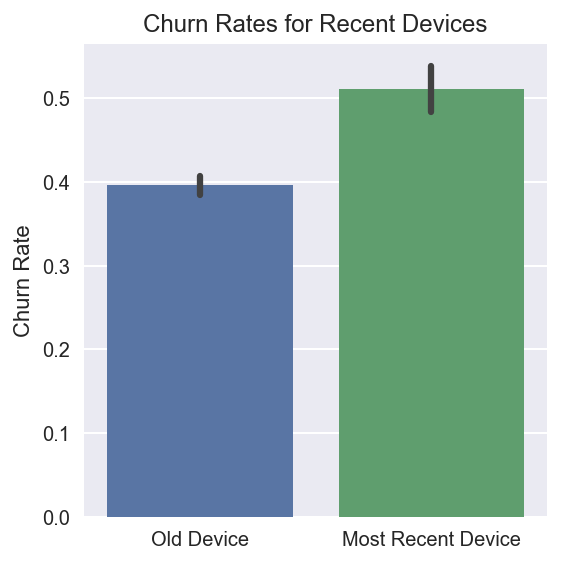

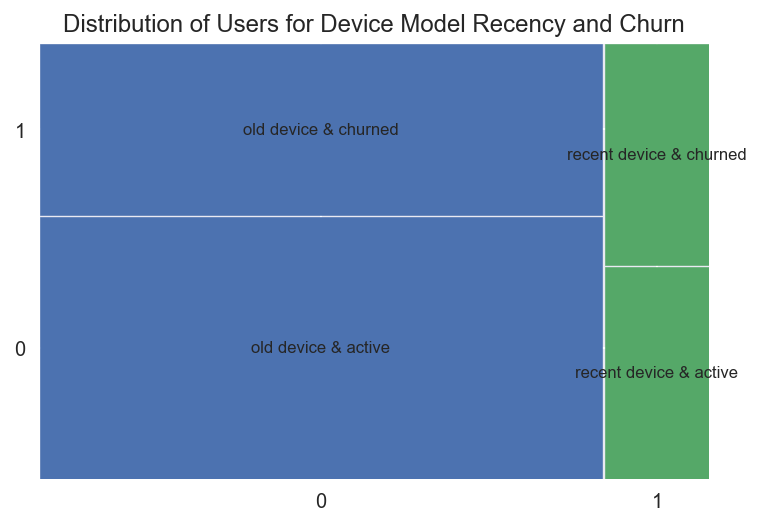

In [79]:
def plot_recentdev_for_churn(plot_data):
    
    # bar chart 
    fp = sns.factorplot(x='recent_device', y='churn', data=plot_data, kind='bar')
    sns.plt.title('Churn Rates for Recent Devices')

    fp.set_xticklabels(['Old Device','Most Recent Device'])
    fp.set_ylabels('Churn Rate')
    fp.set_xlabels('')
    
    #mosaic chart 
    labelizer = lambda k: {('0', '0'): 'old device & active', ('0', '1'): 'old device & churned', #set labels
                      ('1', '0'): 'recent device & active', ('1', '1'): 'recent device & churned'}[k] 
    props = lambda key: {'color': '#4C72B0' if '0' == key[0] else '#55A868'} #set colors
    mosaic(plot_data, ['recent_device','churn'], labelizer=labelizer, properties=props,
               title='Distribution of Users for Device Model Recency and Churn') 
    plt.show()
    
plot_recentdev_for_churn(people[['recent_device','churn']])

Old Devices are less likely to churn, keeping in mind that the sample size for most recent devices are quite small. This could be due to the fact that, people who are always buying the most recent devices are downloading and trying many apps with less tolerance in sticking with one app, thus they are more likely to churn. 

In [80]:
people = people.drop('ios_device_model', axis=1)#drop device model column

# iOS Version

In [81]:
people.head()

,city,last_seen,country_code,ios_version,ios_app_version,registered,signup_date,app_release,churn,recent_device
0,Istanbul,2016-02-10,TR,8.4.1,1.1.1,0,2015-09-04 11:22:29,1.0,0,0
1,Istanbul,2015-12-26,TR,8.1.3,1.1.1,0,2015-12-26 04:12:42,1.0,1,0
2,Petaluma,2016-02-13,US,9.2.1,1.2.8,1,2016-02-13 13:20:42,1.2,1,0
3,Santa Rosa,2016-02-15,US,9.2.1,1.2.8,0,2016-02-15 05:53:24,1.2,1,0
4,Shreveport,2016-03-24,US,8.1.2,1.2.8,1,2016-02-20 11:17:02,1.2,0,0


In [82]:
people[['ios_version', 'app_release']].isnull().sum()
# no missing values 

ios_version    0
app_release    0
dtype: int64

Unlike the model version, keeping the operating system updated is a much stronger indicator of tech savviness which is not related to many other factors. Apple is quite known for the rate of which Apple users keep their operating system updated. In Android devices, this rate is much smaller. This is also the reason why most tech startups launch in Apple Store before building an Android version. Altough Android devices used is higher in numbers compared to Apple mobile phones, A user base that is much less tech savvy, uses and trusts their devices less are much less likely to make purchases over their smartphone, where all the iOS applications are monetised. 

For both of these columns, the idea will be the same as device model number mentioned above. We can create a column that checks wether the user had the most recent iOS version/app release during the period that they have used the app. Second approach would then be converting versions to integers in linear scale where the differences are always 1. However, the second approach may introduce bias in our model since it favours most recent users. Therefore, I will initially use boolean column and then revisit this part and assess the effects on our model. 

In [83]:
people['ios_version'].value_counts().head()

9.2.1     2127
9.3.1     1143
10.2.1     966
9.3.2      957
9.3        791
Name: ios_version, dtype: int64

Building the data dictionary for each ios version with their corresponding release dates. 

In [84]:
ios_release_dates = [datetime(2016, 1, 19), datetime(2016, 3, 31), 
                     datetime(2017, 1, 23), datetime(2016, 5, 16), 
                    datetime(2016, 3, 21), datetime(2016, 12, 12),
                    datetime(2015, 10, 21), datetime(2015, 12, 8),
                    datetime(2016, 9, 23), datetime(2016, 10, 31), 
                    datetime(2016, 8, 25), datetime(2016, 8, 4), 
                    datetime(2016, 7, 18), datetime(2016, 7, 7),
                    datetime(2017, 4, 3), datetime(2015, 4, 8), 
                    datetime(2015, 8, 13), datetime(2015, 6, 30), 
                    datetime(2015, 9, 30), datetime(2014, 12, 9), 
                    datetime(2017, 3, 27), datetime(2015, 6, 8), 
                    datetime(2015, 1, 27), datetime(2016, 10, 24), 
                    datetime(2015, 3, 9), datetime(2014, 10, 20), 
                    datetime(2015, 9, 23), datetime(2016, 9, 13), 
                    datetime(2014, 11, 17), datetime(2014, 9, 25), 
                    datetime(2017, 4, 24), datetime(2014, 9, 17), 
                    datetime(2016, 10, 17)]


In [85]:
#convert dictionary to dataframe 
version_release = pd.DataFrame({'release_date': ios_release_dates, 
                                'ios_version':people['ios_version'].value_counts().keys().values})

In [86]:
#using recent_checker method used in Device Models section and assign the results to new column  
people['recent_version'] = recent_checker(people['last_seen'],people['ios_version'], version_release, 5)

In [87]:
people['recent_version'].value_counts()
#version recency is quite balanced among users

1    5430
0    3894
Name: recent_version, dtype: int64

In [88]:
people = people.drop('ios_version', axis=1)#drop ios version

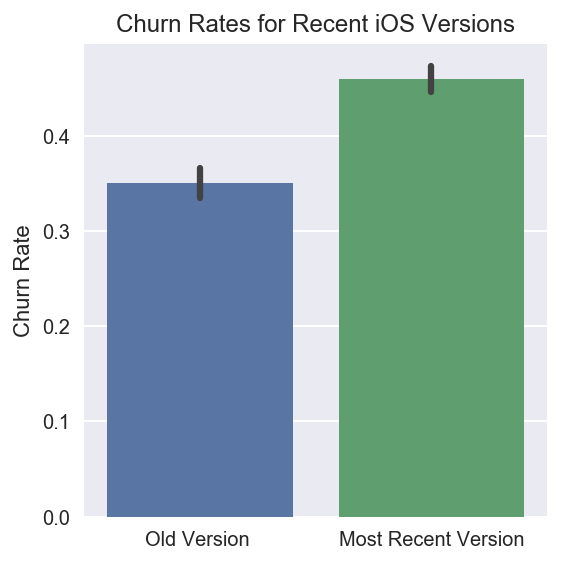

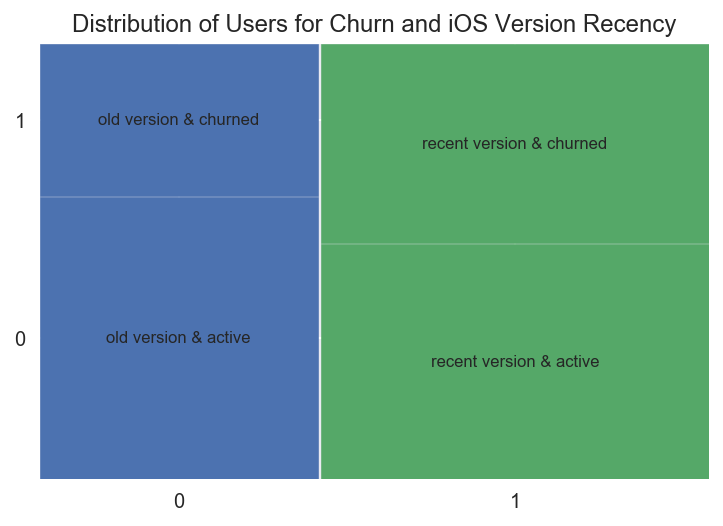

In [89]:
def plot_recentver_for_churn(plot_data):
    
    # bar chart 
    fp = sns.factorplot(x='recent_version', y='churn', data=plot_data, kind='bar')
    sns.plt.title('Churn Rates for Recent iOS Versions')

    fp.set_xticklabels(['Old Version ','Most Recent Version'])
    fp.set_ylabels('Churn Rate')
    fp.set_xlabels('')
    
    #mosaic chart 
    labelizer = lambda k: {('0', '0'): 'old version & active', ('0', '1'): 'old version & churned', #set labels
                      ('1', '0'): 'recent version & active', ('1', '1'): 'recent version & churned'}[k] 
    props = lambda key: {'color': '#4C72B0' if '0' == key[0] else '#55A868'} #set colors
    mosaic(plot_data, ['recent_version','churn'], labelizer=labelizer, properties=props,
               title='Distribution of Users for Churn and iOS Version Recency') 
    plt.show()
    
plot_recentver_for_churn(people[['recent_version','churn']])

iOS Version Recency shows similar behaviour as device model recency, which increases our confidence in our assumption of people who buy most recent versions & always update their phones are more likely to try out may apps, thus less likely to stick with one app. This time sample sizes between classes are more balanced, again, increasing our confidence. 

In [90]:
from scipy.stats import pearsonr

In [91]:
pearsonr(people.recent_device, people.recent_version)

(0.12051053247775156, 1.6587503290049578e-31)

It is quite surprising to see pearsonr value is quite small, meaning that recent device and recent version is not correlated with each other. Small p-value indicates that we can reject null-hypothesis and take the correlation value for granted. It could be that having the most recent device is more about the income level and recent device is more about tech-savvyness. 

# App Release

Each churned user will have most recent app release because they churned on the day of download (except 63 users). This will cause bias in our model, therefore I will use this feature as categorical.

In [92]:
people['app_release'].isnull().sum()
# no missing values 

0

In [93]:
people.app_release.value_counts().head()

1.3.2    2821
1.3.3    1742
1.4.3    1298
1.2      1198
1.3.1     782
Name: app_release, dtype: int64

In [94]:
def plot_app_release_counts(x_vals, y_vals):
    fig = plt.figure(figsize=(15,5)) #set figure size
    ax = fig.gca() #get axis

    ax.bar(x_vals, y_vals, label='App Release-User Distribution') # set scatter plot 

#     ax.set_xticklabels(people['ios_app_release'].value_counts().keys())
    ax.set_xlim((-0.5,16)) #set x and y axis limits 

    ax.axvline(6.5, color='r', label='Cut-off Value') #threshold value line 
    
    ax.set_xlabel('App Release Versions')#set labels 
    ax.set_ylabel('Number of Users')
    ax.set_title('App Release Versions per City')

    plt.legend()
    plt.show()

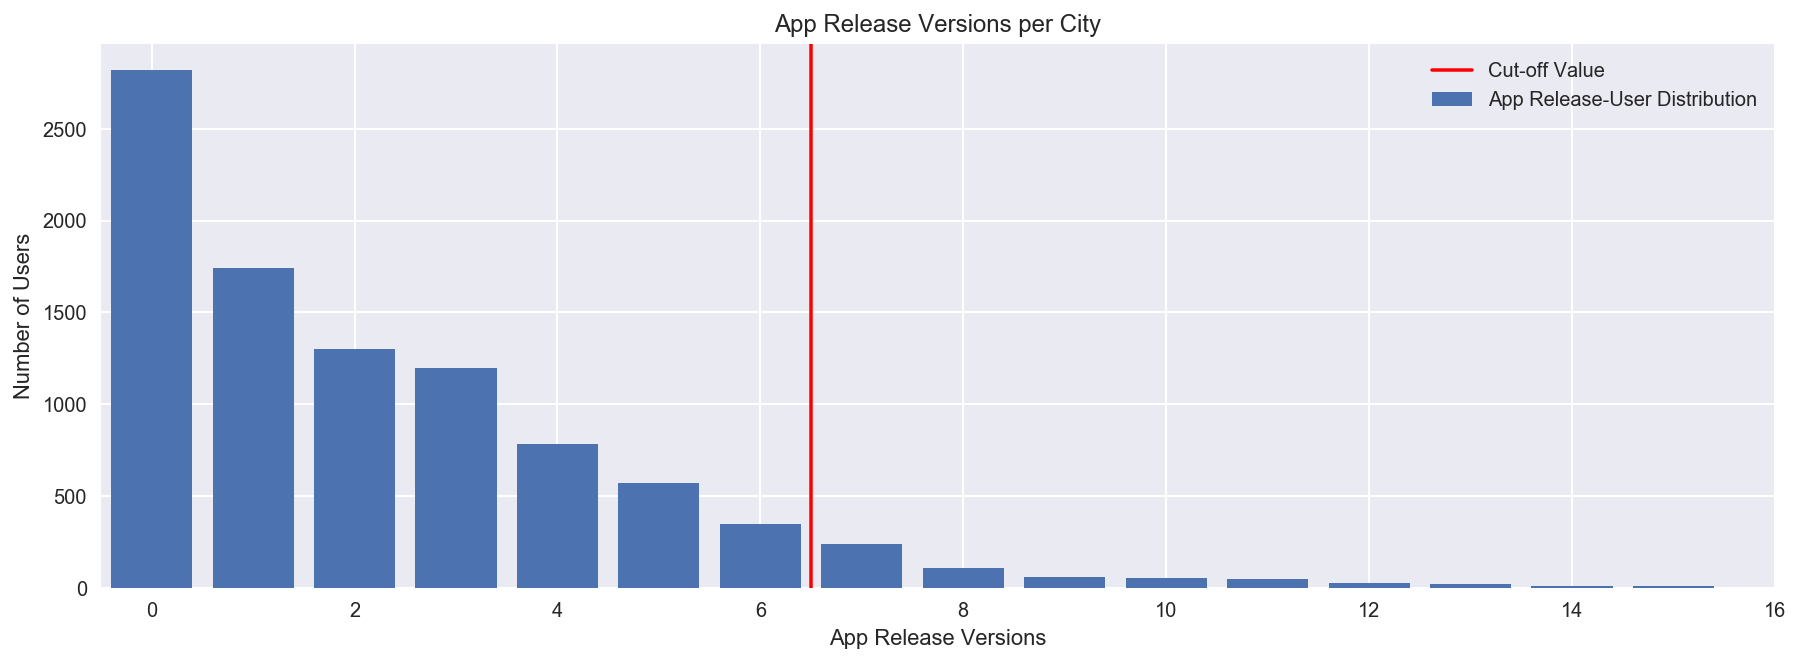

In [95]:
app_release_counts = people['app_release'].value_counts().values #set y values 
x_values = range(0,len(app_release_counts)) #x from 0 to number of citites-1
plot_app_release_counts(x_values, app_release_counts)

Find app release versions that has more than 250 users and only keep those. Assign the rest of the classes as 'other'. This is not to increase feature space dimensionality while retaining significant information. 

In [96]:
over_250 = (people['app_release'].value_counts().values > 250)
picked_releases = people['app_release'].value_counts()[over_250].keys()
people['app_release'] = people['app_release'].map(lambda x: x if x in picked_releases else 'other')

In [97]:
people = people.drop('ios_app_version', axis=1)# drop app version  

In [98]:
people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9324 entries, 0 to 10477
Data columns (total 9 columns):
city              8781 non-null object
last_seen         9324 non-null datetime64[ns]
country_code      9320 non-null object
registered        9324 non-null int64
signup_date       9324 non-null datetime64[ns]
app_release       9324 non-null object
churn             9324 non-null int64
recent_device     9324 non-null int64
recent_version    9324 non-null int64
dtypes: datetime64[ns](2), int64(4), object(3)
memory usage: 728.4+ KB


# City & Country

In [99]:
people.columns

Index([          u'city',      u'last_seen',   u'country_code',
           u'registered',    u'signup_date',    u'app_release',
                u'churn',  u'recent_device', u'recent_version'],
      dtype='object')

There are multiple columns providing information about the geo-location of the user. It is crucial to understand how this information is obtained by Mixpanel. Going through Mixpanel website; these fields are calculated by users obtained IP address and running it through a third party IP geo-locator named MaxMind. Lets skim through the values.

In [100]:
geo_cols = ['city', 'country_code'] #geo-location specific columns
people[geo_cols].head(20).T #checking values 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
city,Istanbul,Istanbul,Petaluma,Santa Rosa,Shreveport,Zagreb,Schiedam,Istanbul,Wethersfield,Istanbul,Almaty,Langenselbold,Izmir,Munich,Palt,Calabasas,Nova Friburgo,Amsterdam,Gaziantep,Ankara
country_code,TR,TR,US,US,US,AT,NL,TR,US,TR,KZ,DE,TR,DE,AT,US,BR,NL,TR,TR


Lets check for null values; 

In [101]:
people[geo_cols].isnull().sum()

city            543
country_code      4
dtype: int64

City is missing around 500 entries, even though it is a very small proportion of the dataset, I will investigate the cause. 

In [102]:
people[people.city.isnull()].head(3)

,city,last_seen,country_code,registered,signup_date,app_release,churn,recent_device,recent_version
20,NaN,2016-03-23,TR,0,2016-03-23 11:46:01,1.3.2,1,0,1
49,NaN,2016-02-11,US,0,2016-02-11 10:44:02,1.2,1,1,1
50,NaN,2016-02-12,JP,0,2016-02-12 00:42:03,1.2,1,0,1


When I was going through the null values, I also came across some entries where there was a mismatch between city and country codes. Investigating the cause further, I came across a very important post;

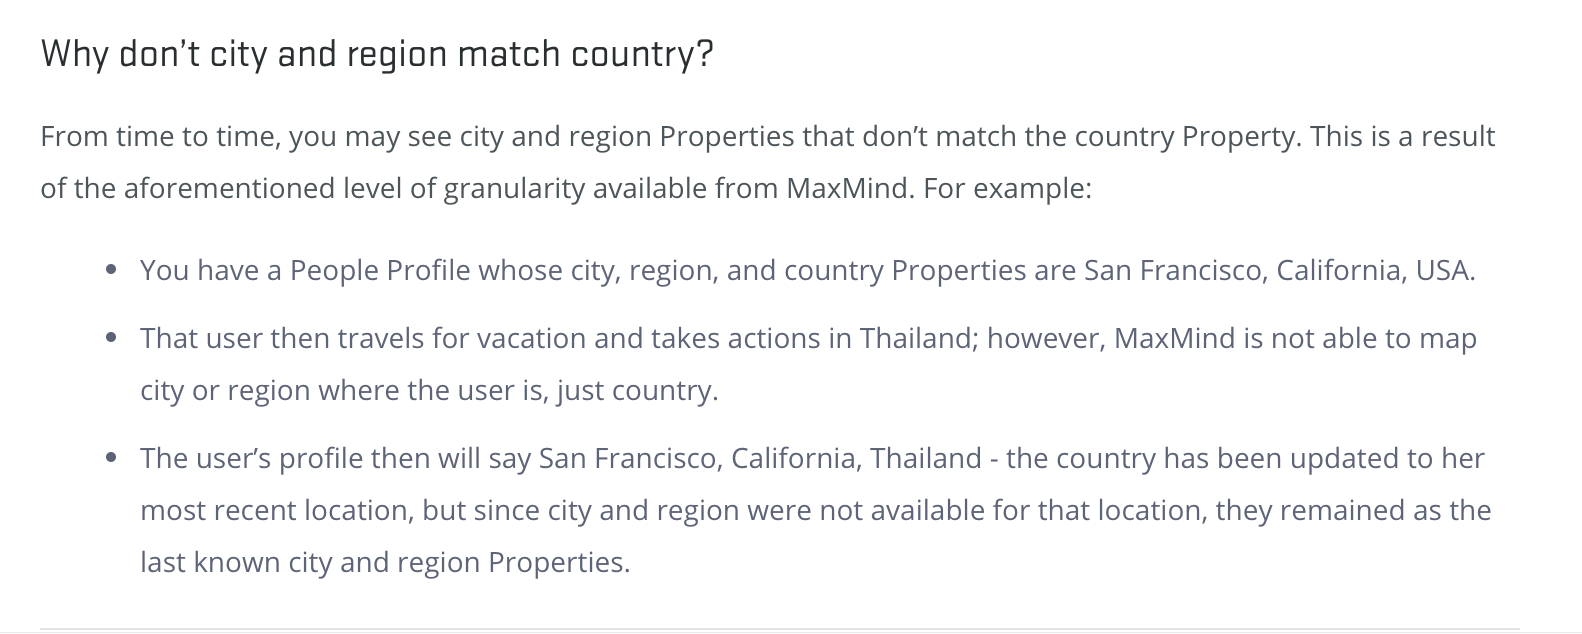

In [103]:
Image(filename='./assets/geo_location.png') # saved to local directory from Mixpanel website 

Based on this information, we can conclude that country code is the most accurate geo-location related column. However, I am assuming that the mismatches mentioned above should correspond to a very small subset of our dataset, therefore it is still useful to keep these columns. 

Since the missing values for city and region is a very small percentage of our dataset (around 5%) we can drop these values. 

In [104]:
people = people[~people.city.isnull()]#drop rows with missing city values

In [105]:
people[geo_cols].isnull().sum() 
# it looks like all the missing values for geo-location features were mutual, we have no remaining null values. 

city            0
country_code    0
dtype: int64

I will convert cities to lowercase and replace white space characters with underscore for cleaning. 

In [106]:
people['city'] = people.city.map(lambda x: x.lower().replace(' ', '_')) #lowercase and underscore city column 

lets quickly observe how country codes are distributed among users.

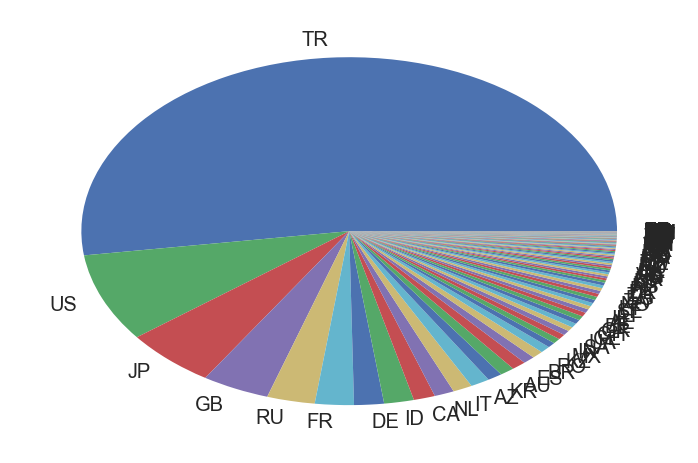

In [107]:
# plot pie chart of country code value counts 
plt.pie(people['country_code'].value_counts().values, #total users for each country 
        labels=people['country_code'].value_counts().keys()) # country codes as labels 
plt.show()

It looks like there is a good bunch of users from Turkey, US, Japan, United Kingdom, Russia and France. We can categorise all the rest in one category 'OTHER'. 

In [108]:
top_country_codes = people.country_code.value_counts()[:5].keys() # get top 6 country codes in a list
people['country_code'] = people.country_code.map(lambda x: x if x in top_country_codes else 'other') #assign OTHER to others

Lets have a look at how some features are affected by different cohorts from different countries.

In [109]:
print 'average numerical features per country'
country_means = people.groupby('country_code').mean() #group users by country and calculate mean of numerical columns 
country_means

average numerical features per country


,registered,churn,recent_device,recent_version
country_code,,,,
GB,0.360335,0.388268,0.312849,0.553073
JP,0.166667,0.473251,0.207819,0.720165
RU,0.444882,0.444882,0.094488,0.452756
TR,0.382468,0.380070,0.137157,0.612298
US,0.384189,0.454924,0.242718,0.599168
other,0.503367,0.377104,0.133838,0.506734


Findings; 

1. Users from United Kingdom uses the application way more than other users. Even though we know that majority of our users are from Turkey, it looks like a download may be worth more if its from the UK.
2. United Kingdom and other country group again leads at the like functionality. It looks like there is a (expected)  correlation between number of sessions and total like count. 
3. There is a very interesting pattern here; Russia and Other both have higher signup rate. It looks like users from these countries are less strict on sharing their personal details.   

I will also assign 'OTHER' to cities with entries lower than a certain threshold. Lets decide on that threshold. 

In [110]:
def plot_city_counts(x_vals, y_vals):
    fig = plt.figure(figsize=(15,5)) #set figure size
    ax = fig.gca() #get axis

    ax.bar(x_vals, y_vals, label='City-User Distribution') # set scatter plot 

    # ax.set_xticklabels(people.city.value_counts().keys())
    ax.set_xlim((0,15)) #set x and y axis limits 
    ax.set_ylim((0,700))

    ax.axvline(5.5, color='r', label='Cut-off Value') #threshold value line 
    
    ax.set_xlabel('Cities')#set labels 
    ax.set_ylabel('Number of Users')
    ax.set_title('Number of Users per City')

    plt.legend()
    plt.show()

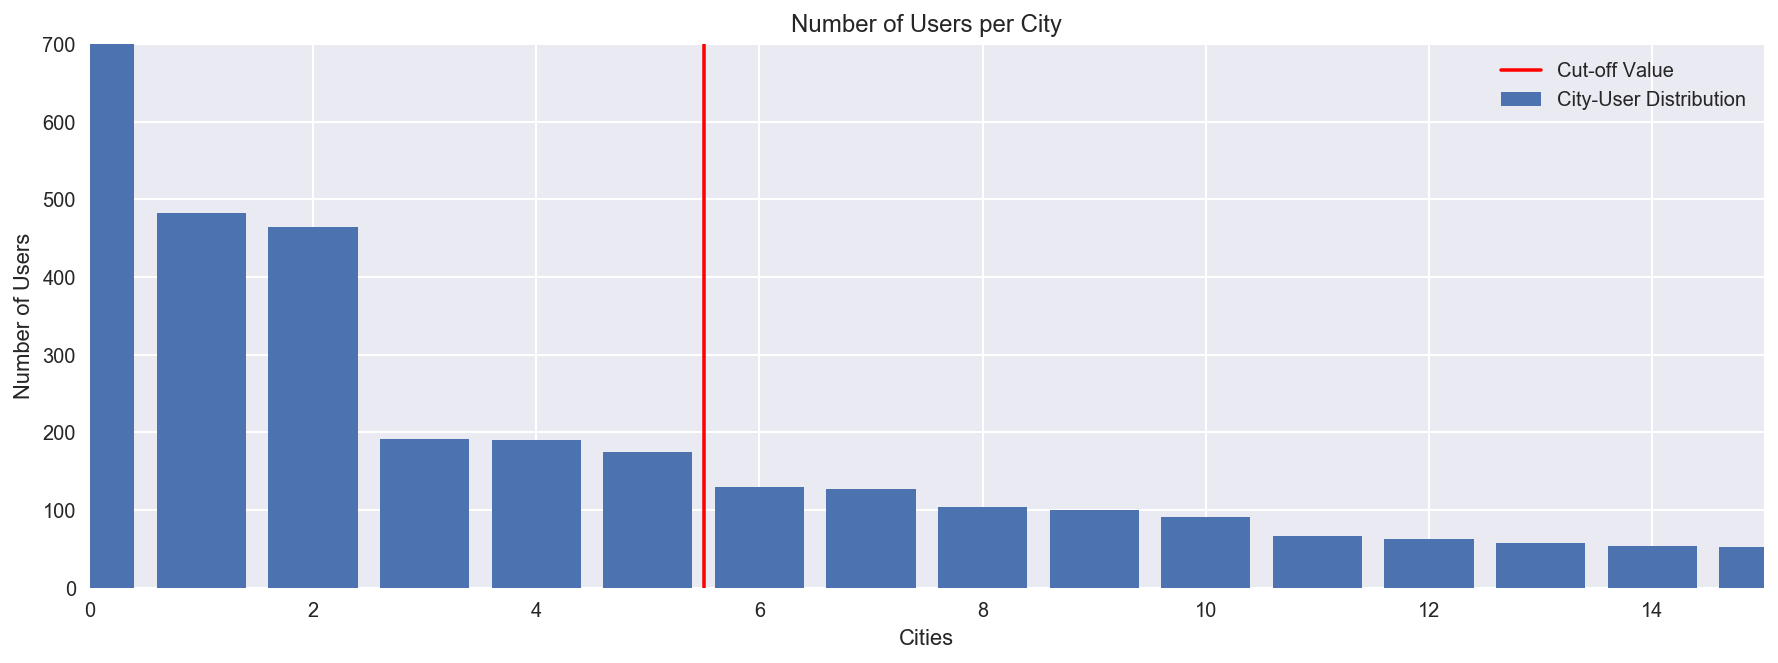

In [111]:
city_counts = people.city.value_counts().values #set y values 
x_values = range(0,len(city_counts)) #x from 0 to number of citites-1
plot_city_counts(x_values, city_counts)

Based on the chart above, I will keep the cities that have more than 100 users. I can obtain the top city names from value counts keys.

In [112]:
top_cities = people.city.value_counts().loc[:'bursa']
top_cities

istanbul    2337
ankara       482
izmir        464
london       191
tokyo        190
bursa        175
Name: city, dtype: int64

In [113]:
top_cities = top_cities.keys()#only keep the names 
people.city = people.city.map(lambda x: x if x in top_cities else 'other') #assign all other as OTHER

In [114]:
people.city.value_counts() 
# successfully transformed city values 

other       4942
istanbul    2337
ankara       482
izmir        464
london       191
tokyo        190
bursa        175
Name: city, dtype: int64

In [115]:
def plot_categorical_churn_bar(bar_data, title, width=0.35, label_0='active', label_1='churned'):
    fig, ax = plt.subplots(figsize=(20,7))   
    
    #set data 
    active_counts = bar_data[0].values
    churn_counts = bar_data[1].values
    ind = np.arange(len(active_counts))  # the x locations for the groups

    #bar graphs for both groups 
    rects1 = ax.bar(ind, active_counts, width, color='r')
    rects2 = ax.bar(ind + width, churn_counts, width, color='y')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of Users')
    ax.set_title(title)
    
    # calc xticks and set labels 
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(bar_data.index.levels[1].values)

    ax.legend((rects1[0], rects2[0]), (label_0, label_1))

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

In [116]:
countries_for_plot = pd.pivot_table(people,values='city', index=['churn', 'country_code'], aggfunc=lambda x: x.count())
countries_for_plot

churn  country_code
0      GB               219
       JP               256
       RU               141
       TR              2843
       US               393
       other           1480
1      GB               139
       JP               230
       RU               113
       TR              1743
       US               328
       other            896
Name: city, dtype: int64

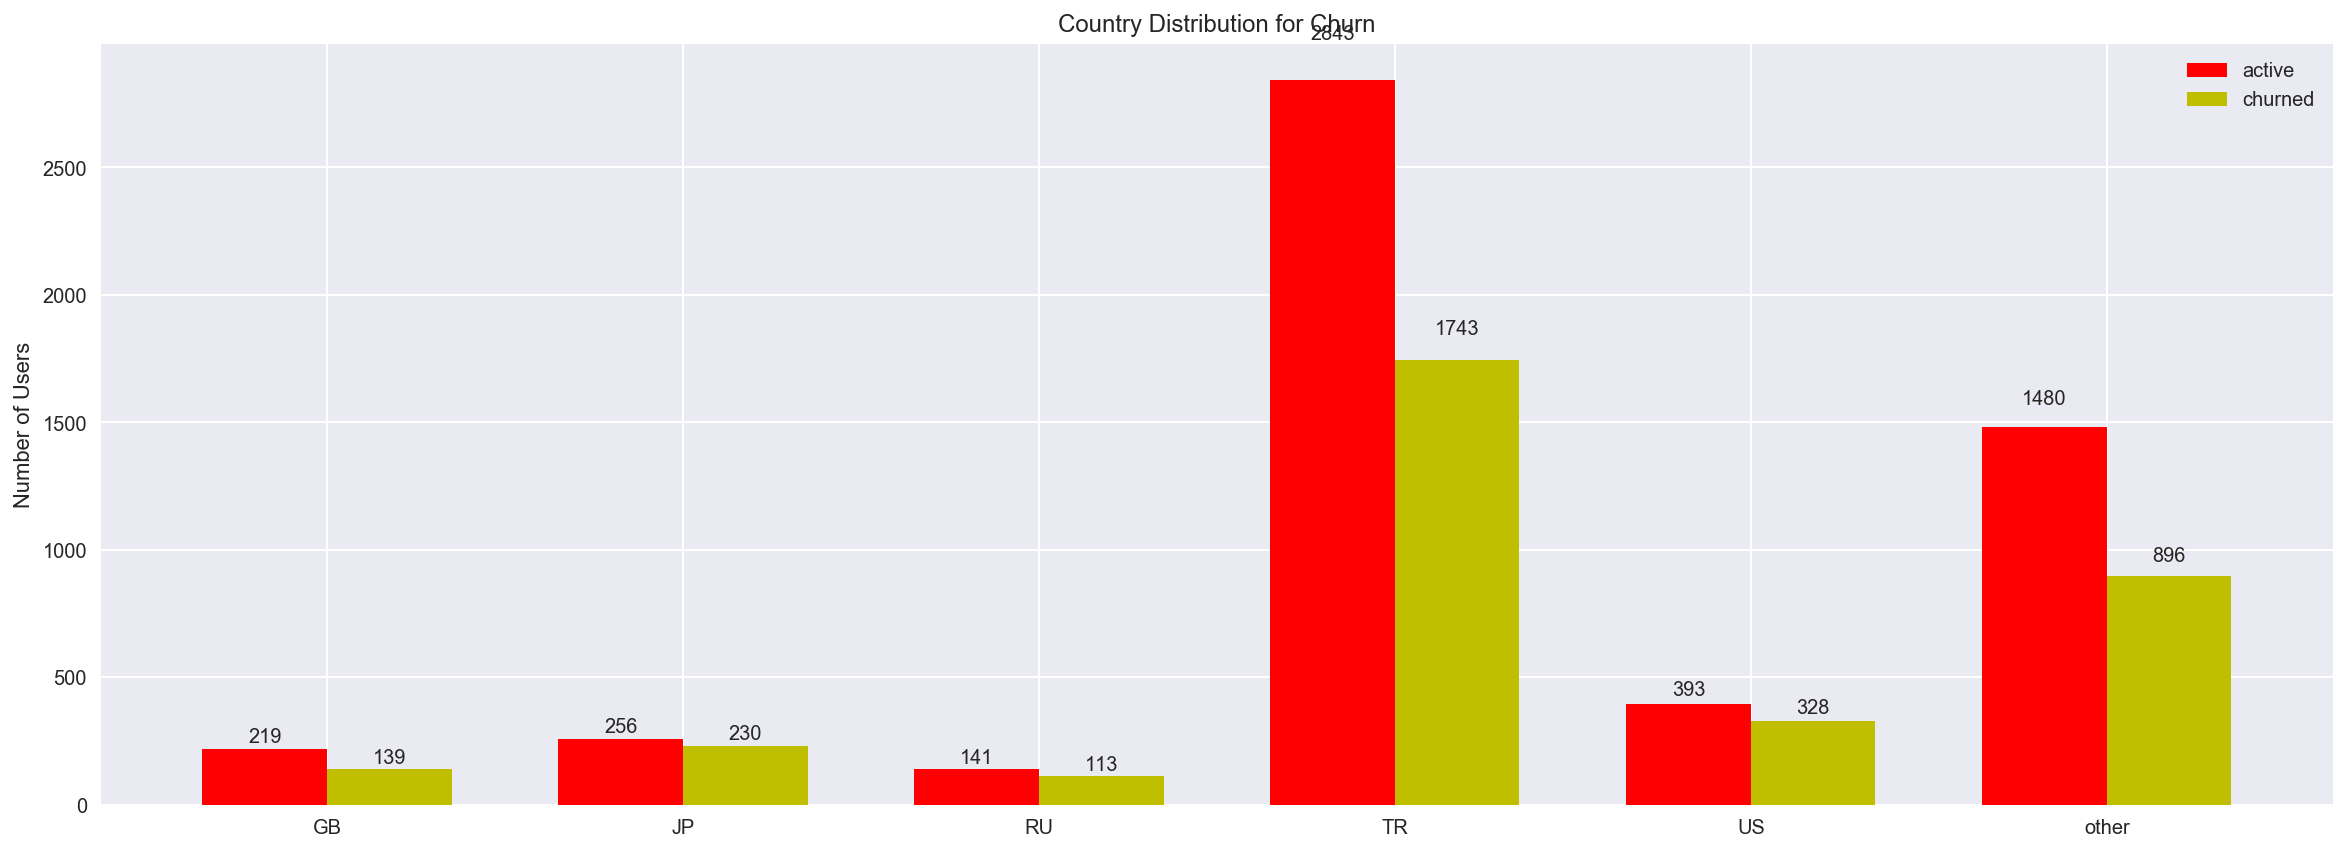

In [117]:
plot_categorical_churn_bar(countries_for_plot, 'Country Distribution for Churn')

Users that are in Turkey and the remaining countries are less likely to churn than other categorical variables in the countries set. This should be due to a particular group of users we have reached through marketing campaigns over instagram, keeping in mind that our Instagram following is mainly from Turkey. Lets now look at the cities.  

In [118]:
cities_for_plot = pd.pivot_table(people,values='country_code', index=['churn', 'city'], aggfunc=lambda x: x.count())
cities_for_plot

churn  city    
0      ankara       299
       bursa        110
       istanbul    1488
       izmir        299
       london       112
       other       2916
       tokyo        108
1      ankara       183
       bursa         65
       istanbul     849
       izmir        165
       london        79
       other       2026
       tokyo         82
Name: country_code, dtype: int64

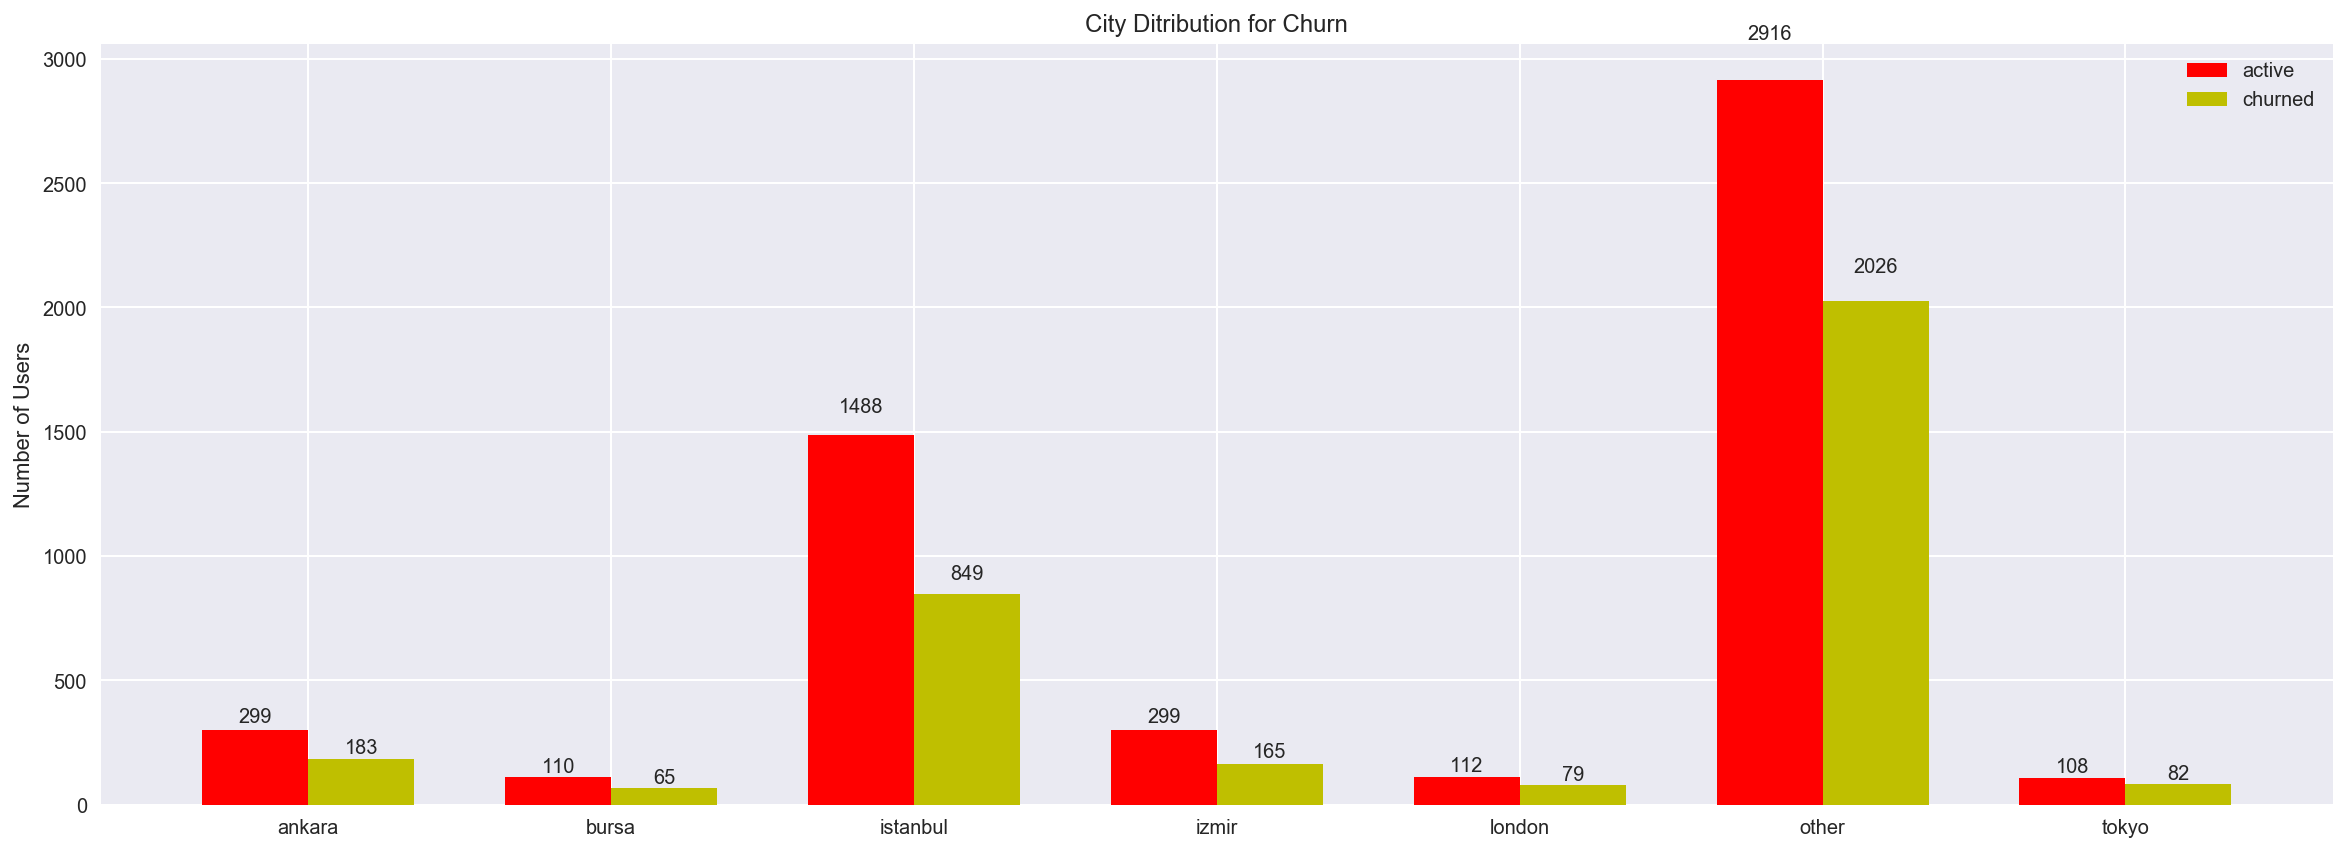

In [119]:
plot_categorical_churn_bar(cities_for_plot, 'City Ditribution for Churn')

Same findings apply for cities as countries, this should be the cohort that is following us on Instagram, that has a particular music taste that aligns with the music picked in the app. 

# Acquisition Cohorts

In [120]:
people['signup_date'] = people.signup_date.map(lambda x: x.date())#conver to date

In [121]:
people['signup_date'] = people.signup_date.map(lambda x: datetime.combine(x, datetime.min.time()))#assign 0 time

Lets breakdown downloads by countries to figure out the acquisition channels. We have mainly marketed the app over collaborating with popular Instagram accounts in Turkey and getting featured on app websites around the world. 

In [122]:
people.country_code.value_counts()#Lets look at the downloads 

TR       4586
other    2376
US        721
JP        486
GB        358
RU        254
Name: country_code, dtype: int64

In [123]:
df = pd.DataFrame(people.groupby('signup_date')['country_code'].value_counts())#reshaping before plots

In [124]:
df.head()

country_code
signup_date country_code              
2015-09-01  GB                       1
            US                       1
2015-09-04  other                    3
            RU                       1
            TR                       1

In [125]:
def get_geo_downloads_df(country_code):#return number of downloads over dates for given country
    other_downloads = df.iloc[df.index.get_level_values('country_code') == country_code]
    other_downloads.index = other_downloads.index.get_level_values('signup_date')
    other_downloads = other_downloads.rename(columns={'country_code':country_code})
    return other_downloads

In [126]:
tr_downloads = get_geo_downloads_df('TR')
tr_downloads.head()#checking final shape

,TR
signup_date,
2015-09-04,1
2015-09-05,4
2015-09-06,1
2015-09-08,1
2015-09-09,2


Below are the main acquisition events (and their corresponding dates), such as getting featured on Producthunt.com's top 10, collaboration post by popular Instagra accounts (differtv etc.) 

In [127]:
acquisition_events = {'producthunt.com': datetime(2016, 2, 11), 'insta_differtv':datetime(2016, 3, 15), 
                      'insta_kisacikmuzik':datetime(2016, 3, 23),
                     'appadvice.com':datetime(2016, 2, 11), 'appchasers.com':datetime(2016, 3, 21),
                     'media.kawa-colle.jp':datetime(2016, 2, 12)}

In [128]:
def plot_downloads_per_country(xmin, xmax, acquisition_events):
    """
    Plot downloads over each country and indicate acquisiton events by vertical lines 
    """
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.gca()
    for country_code in people.country_code.unique():    
        ax.plot(get_geo_downloads_df(country_code), label=country_code)#using the method created above
    
    for i, acquisition_event in enumerate(acquisition_events.keys()):#vertical lines for acquisition events
        ax.axvline(acquisition_events[acquisition_event], ls='--', label=acquisition_event, color='C'+str(i))
        
    ax.set_xlim((xmin, xmax))
    plt.legend()
    plt.show()

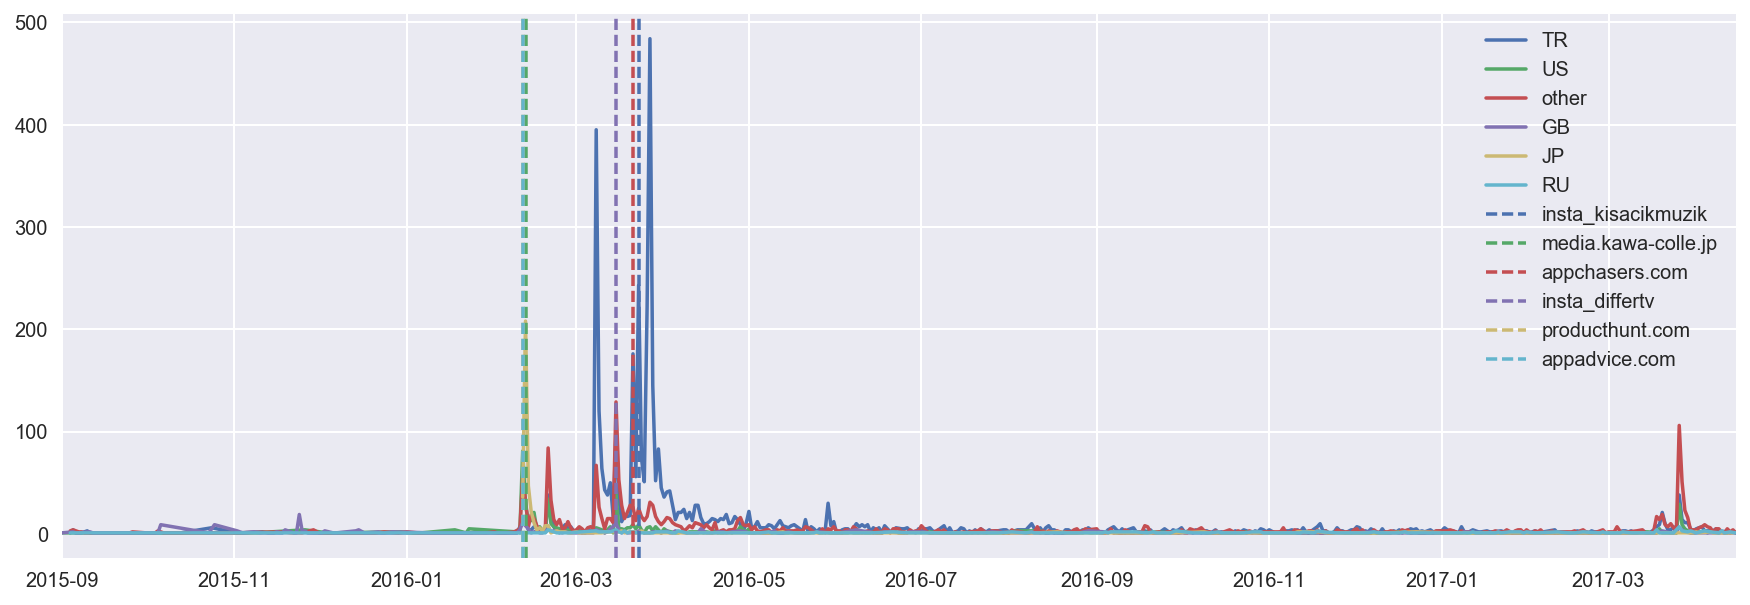

In [129]:
plot_downloads_per_country(people.signup_date.min(), people.signup_date.max(), acquisition_events)

Lets zoom in to the part where for observing highest activity period. 

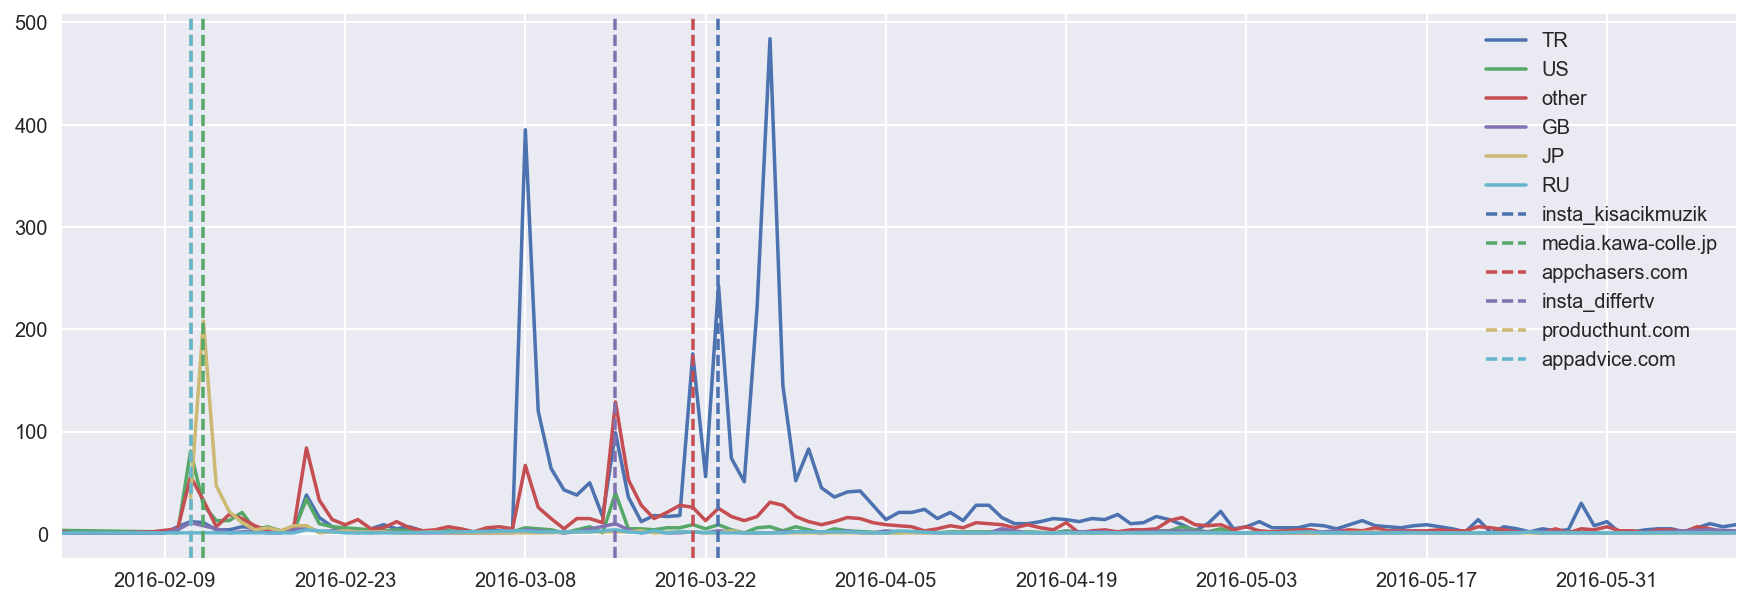

In [130]:
plot_downloads_per_country(datetime(2016, 2, 1), datetime(2016, 6, 10), acquisition_events)

It looks like there is a small offset in Mixpanel data about signup date. Our acquisition events usually correspond to the peak of the download activity, which doesn't make sense, it should correcpond to the start of the incline. I will offset the acquisition event dates so that they are aligned.   

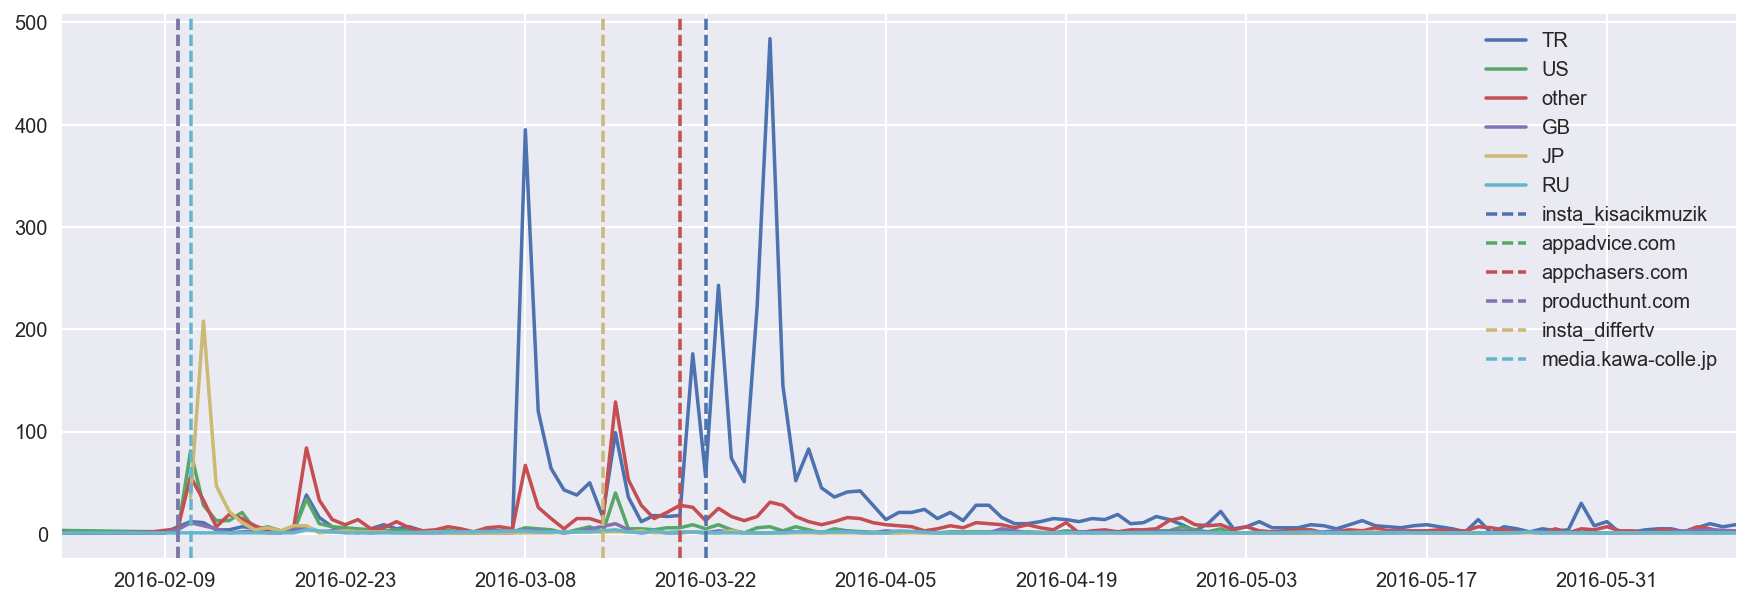

In [131]:
ac_events_offset = {}

for event in acquisition_events.keys():
    ac_events_offset[event] = acquisition_events[event] - timedelta(days=1)#move acquisition event dates by 1 day   
    
plot_downloads_per_country(datetime(2016, 2, 1), datetime(2016, 6, 10), ac_events_offset)#replot

There are some spikes in activity, which we don't know what the acquisiton channel is. Usually this information can be obtained from Apple Developer website, however, such information is missing for Mood Listener. There are 3 substantial spikes that is missing an acquisiton event label, I will set adhoc labels for those groups and categorise rest of the users as 'broad'. Broad label stands for a user that might be coming from anywhere, word of mouth, itunes store search etc.

In [132]:
ac_events_offset['late_feb_other'] = datetime(2016, 2, 19) #first spike with mainly users from OTHER
ac_events_offset['early_mar_tr'] = datetime(2016, 3, 7) #second spike with mainly users from TR
ac_events_offset['late_mar_tr'] = datetime(2016, 3, 25) #third spike with mainly users from TR

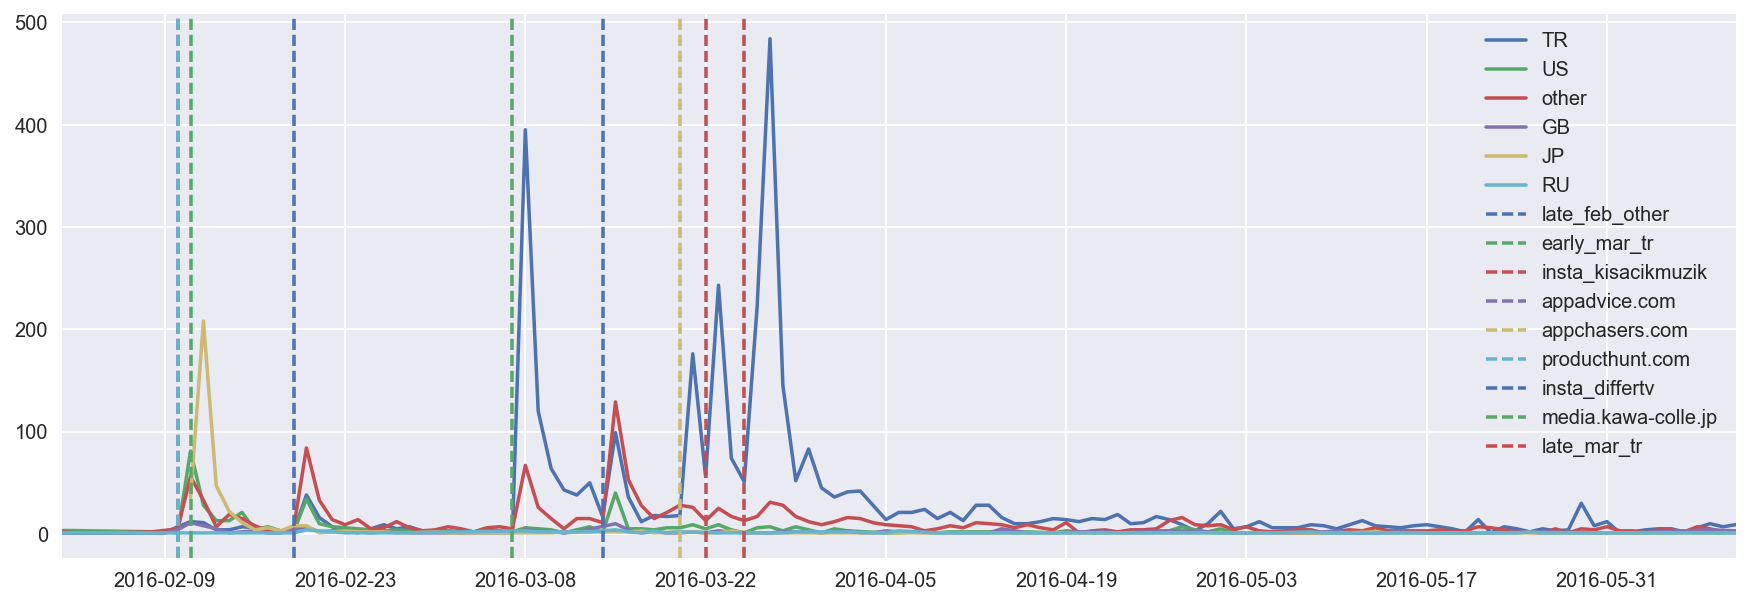

In [133]:
plot_downloads_per_country(datetime(2016, 2, 1), datetime(2016, 6, 10), ac_events_offset)

I will first assign all users as 'broad' then I will overwrite for each acquisition event. 

In [134]:
people['acquisition_cohort'] = ['broad'] * len(people)#assign broad to all users

In [135]:
upper_bound = people.signup_date <= datetime(2016, 2, 17)#assign event to users who downloaded the app within bounds 
lower_bound = people.signup_date >= ac_events_offset['producthunt.com']
country_restriction = people.country_code != 'JP'#there is another acquistion event in Japan at the same time
people.loc[lower_bound & upper_bound & country_restriction,'acquisition_cohort'] = 'producthunt.com'

In [136]:
lower_bound = people.signup_date >= ac_events_offset['media.kawa-colle.jp']#remaining users for same period but from JP
country_restriction = people.country_code == 'JP'
people.loc[lower_bound & upper_bound & country_restriction,'acquisition_cohort'] = 'media.kawa-colle.jp'

In [137]:
def assign_to_cohort(event, u_bound_date):#automate the procedure above for the remaining events 
    upper_bound = people.signup_date <= u_bound_date
    lower_bound = people.signup_date >= ac_events_offset[event]
    people.loc[lower_bound & upper_bound,'acquisition_cohort'] = event

In [138]:
assign_to_cohort('late_feb_other', datetime(2016, 2, 25))#assigning rest of the users with acquisition events/periods
assign_to_cohort('early_mar_tr', ac_events_offset['insta_differtv'])
assign_to_cohort('insta_differtv', ac_events_offset['appchasers.com'])
assign_to_cohort('appchasers.com', ac_events_offset['insta_kisacikmuzik'])
assign_to_cohort('insta_kisacikmuzik', ac_events_offset['late_mar_tr'])
assign_to_cohort('late_mar_tr', datetime(2016, 4, 5))

In [139]:
people.acquisition_cohort.value_counts()
#final state, value counts 

broad                  3980
late_mar_tr            1506
early_mar_tr            917
insta_differtv          554
insta_kisacikmuzik      456
producthunt.com         405
late_feb_other          357
media.kawa-colle.jp     334
appchasers.com          272
Name: acquisition_cohort, dtype: int64

In [140]:
people = people.drop(['signup_date','last_seen'], axis=1)#I don't need these dates anymore

Lets see how each acquisition cohort relates to churn.

In [141]:
def plot_bar_cohort_churn(bar_data, width=0.35, label_0='active', label_1='churned'):
    fig, ax = plt.subplots(figsize=(20,7))   
    
    #set data 
    active_counts = bar_data[0].values
    churn_counts = bar_data[1].values
    ind = np.arange(len(active_counts))  # the x locations for the groups

    #bar graphs for both groups 
    rects1 = ax.bar(ind, active_counts, width, color='r')
    rects2 = ax.bar(ind + width, churn_counts, width, color='y')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of Users')
    ax.set_title('User Counts by Acquisition Cohorts and Churn')
    
    # calc xticks and set labels 
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(bar_data.index.levels[1].values)

    ax.legend((rects1[0], rects2[0]), (label_0, label_1))

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

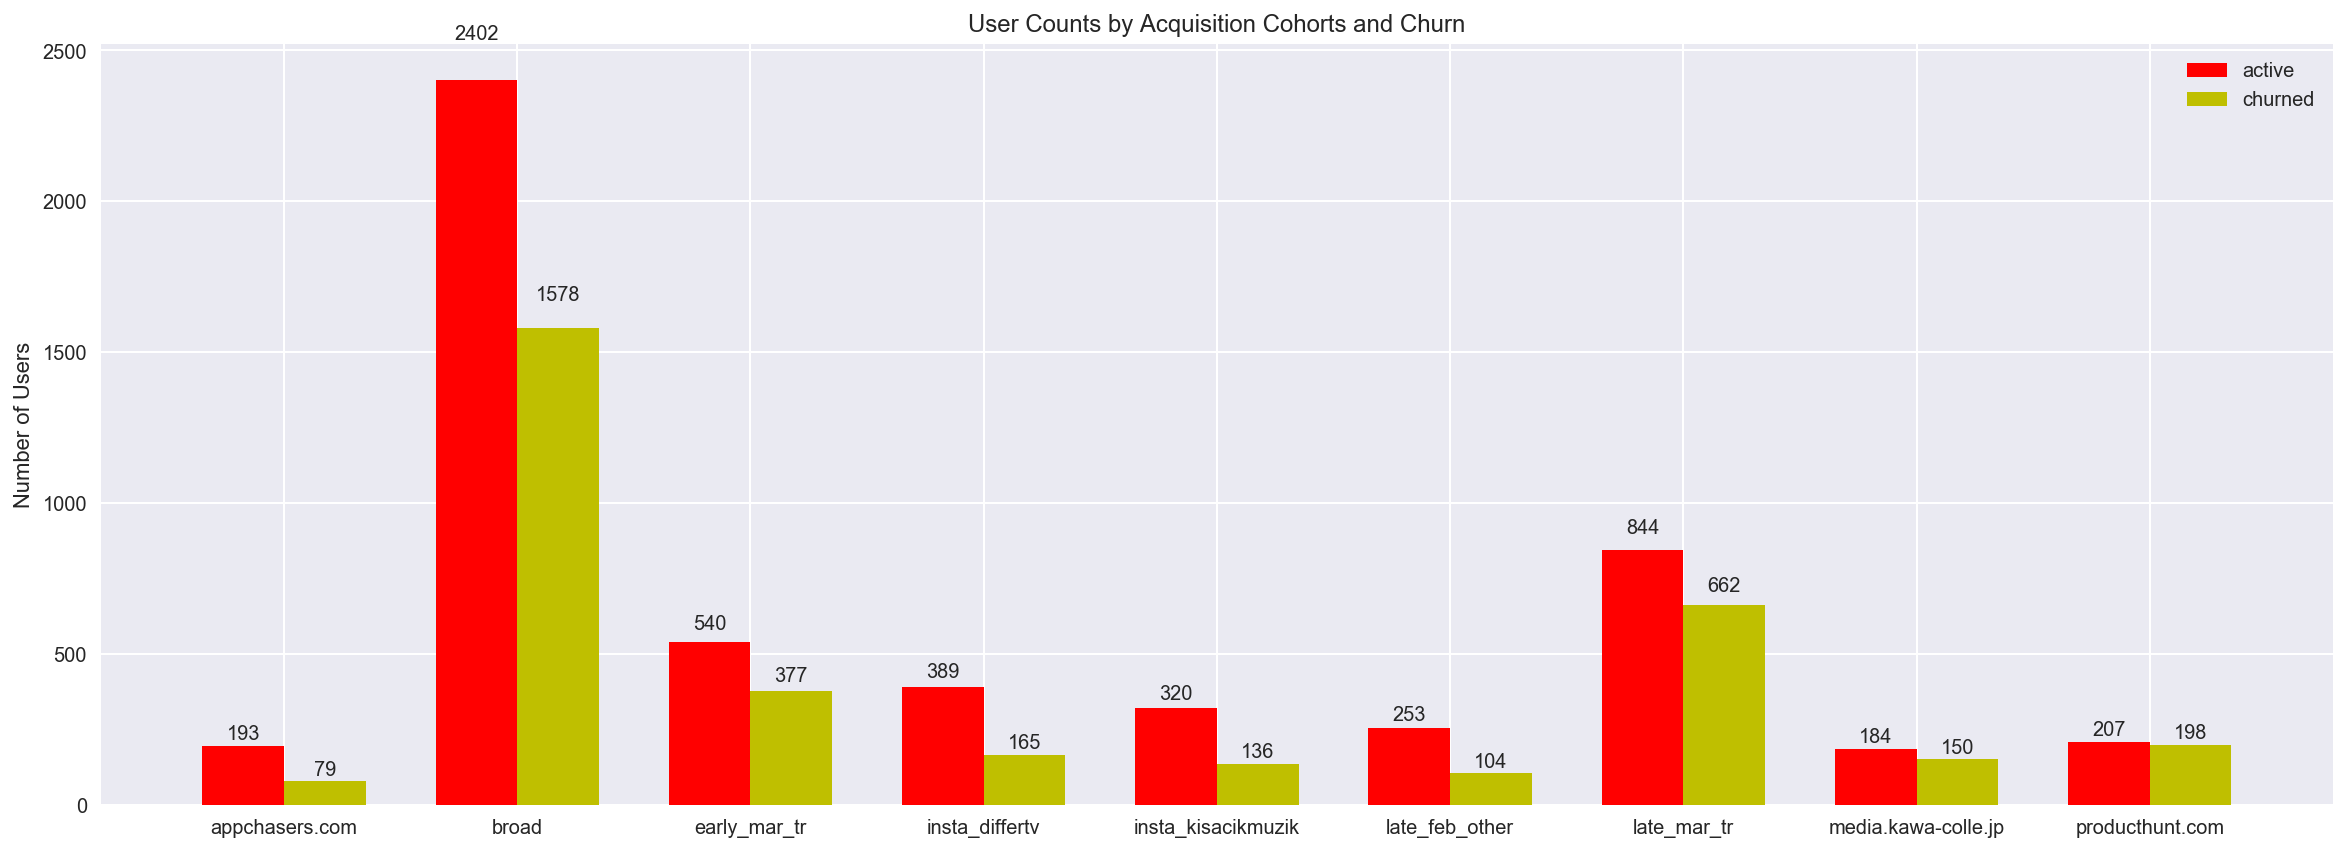

In [142]:
bar_data = pd.pivot_table(people,values='city', index=['churn', 'acquisition_cohort'], aggfunc=lambda x: x.count())
plot_bar_cohort_churn(bar_data)

Findings; 

1. Broad category is less likely to churn, this is probably because they come through word of mouth. Which is a great channel since they trust the people who they have heard the app from. 
2. As expected from the previous section, people who downloaded the app through our Instagram collaboratios with popular accounts in Turkey are less likely to churn. This is because we have identified these accounts by their posts matching our music style. 
3. Its worth finding out the unknown late march acquisition event in Turkey that resulted in active downloads. 

Writing both dataframes to CSV so that I can read it from the Modelling notebook. 

In [143]:
people.to_csv('people.csv')
people_raw.to_csv('people_raw.csv')